# I. Set Up

In [1]:
# PYTHON Imports 
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import math
import statistics
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path
import glob
import os
import ipywidgets as widgets
from IPython.display import clear_output
import sys
import time
import json
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import fnmatch
import pickle
# ASTROPHY Imports
import astropy 
from astropy import stats
# from astropy.table import Table
# from astropy.io import fits
# from sherpa.astro import ui
# # CIAO Imports
# import ciao_contrib.runtool
# from ciao_contrib.runtool import *
# # CUSTOM Imports
# from data_extraction_functions import *
# from data_exploration_functions import *
# from data_representation_functions import *
def list_folders_fun(path):
    """
    DESCRIPTION: List folders in a given directory.
    INPUT: Directory path
    OUTPUT: Folder names in a given directory
    """
    folder_list = [f.name for f in Path(path).iterdir() if f.is_dir()]
    return folder_list

# Specify global path
global_path = '/Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets'
global_folders = list_folders_fun(global_path)

# Custom object hook to convert lists of lists to NumPy arrays
def numpy_hook(obj):
    if isinstance(obj, list):
        # Check if the list contains sublists (i.e. a matrix)
        if isinstance(obj[0], list):
            # Convert the list of lists to a NumPy array matrix
            return np.array(obj)
    # Return all other objects as is
    return obj

# Select dataset
set_widget = widgets.Dropdown(options=global_folders[:],value=global_folders[0],description='Set :',disabled=False); set_widget

Dropdown(description='Set :', options=('Full', 'All', 'Full_extra', 'New', 'Bona'), value='Full')

# II. Load Data

In [2]:
# Set ID
set_id = set_widget.value
files = os.listdir(f'{global_path}/{set_id}/')
input_files = [f for f in files if fnmatch.fnmatch(f, 'hist*nE16*none*.pkl')]
input_widget = widgets.Dropdown(options=input_files[:],value=input_files[0],description='Histogram File :',disabled=False); input_widget

Dropdown(description='Histogram File :', options=('hist2D-Full-nE16-nt24-normnone.pkl', 'hist3D-Full-nE16-nt24…

In [3]:
# Load the DataFrame from the CSV file
input_file = input_widget.value
# Load histogram dictionary
with open(f'{global_path}/{set_id}/{input_file}', 'rb') as f:
    hist_dict = pickle.load(f)
# Flatten histograms in the dictionary and get IDs
ids = hist_dict.keys()
histograms = hist_dict.values()
features = np.array([np.array(h).flatten() for h in histograms])
features[np.isnan(features)] = 0.0
# Load properties
df_properties_input = pd.read_csv(f'{global_path}/{set_id}/properties-input-{set_id}.csv')
df_properties_input = df_properties_input[df_properties_input['obsreg_id'].isin(list(ids))]
df_properties = df_properties_input.drop_duplicates('obsreg_id', keep='first').reset_index()
#Load eventfiles
df_eventfiles_input = pd.read_csv(f'{global_path}/{set_id}/eventfiles-input-{set_id}.csv')
df_properties_global = pd.read_csv(f'{global_path}/{set_id}/properties-{set_id}.csv')
df_properties_global['obsreg_id'] = df_properties_global['obsid'].astype(str) + '_' + df_properties_global['region_id'].astype(str)
df_eventfiles_group = df_eventfiles_input.groupby('obsreg_id')
df_properties_group = df_properties_input.groupby('obsreg_id')

# print("Number of Eventfiles: ", df_eventfiles_group.ngroups)
# print("Number of Property Sets: ", df_properties_group.ngroups)

# Print eventfiles and properties number of IDs
print("Number of Features: ", len(features))
print("Number of Property Sets: ", len(df_properties))
print("Number of Full Property Sets: ", len(df_properties_global))

df_properties_global.head()

Number of Features:  95473
Number of Property Sets:  95473
Number of Full Property Sets:  130232


name        ra        dec  err_ellipse_r0  err_ellipse_r1   
0  2CXO J000000.5-575830  0.002735 -57.975181        2.819565        1.667655  \
1  2CXO J000001.7+003824  0.007280   0.640146        1.093394        0.871849   
2  2CXO J000002.4+004444  0.010189   0.745732        0.746484        0.723548   
3  2CXO J000002.4+321750  0.010280  32.297465        1.067836        0.944977   
4  2CXO J000002.9-350332  0.012314 -35.059185        0.855386        0.735828   

   err_ellipse_ang  significance likelihood_class  conf_flag  sat_src_flag   
0        91.090421      8.522222             TRUE       True         False  \
1       104.849964      5.485207             TRUE      False         False   
2        34.468703      5.774224             TRUE      False         False   
3       115.769199      5.028571             TRUE      False         False   
4       172.590089     16.266113             TRUE      False         False   

   ...  hard_hs_hilim  var_prob_b  var_prob_h  var_prob_m  var_prob_s   
0  ...      -0.267958    0.085129    0.121377    0.376451    0.175421  \
1  ...       0.269207    0.612624    0.585561    0.519756    0.678199   
2  ...       0.003123    0.425172    0.465109    0.489993    0.754087   
3  ...       0.222986    0.154076    0.177304    0.548595         NaN   
4  ...      -0.377889    0.067012    0.113151    0.235485    0.080282   

   var_index_b  var_index_w      livetime  detector  obsreg_id  
0          0.0          NaN  30146.733203    ACIS-6    9335_26  
1          1.0          NaN  23719.527217    ACIS-7    11591_1  
2          0.0          NaN  23719.527217    ACIS-7   11591_22  
3          0.0          NaN  24735.257397    ACIS-3    20515_8  
4          0.0          NaN   9937.243792    ACIS-6    15712_4  

[5 rows x 76 columns]

# III. Display

SHOW

In [4]:
# Load DBSCAN RESULT
files = os.listdir(f'{global_path}/{set_id}/')
dbscan_files = [f for f in files if fnmatch.fnmatch(f, 'DBSCANres*hist2D*PCA15*11*EPS2.1*MS22*csv')] #PCA 2D
dbscan_files = [f for f in files if fnmatch.fnmatch(f, 'DBSCANres*11*EPS1.65*MS28*csv')] #PCA 3D
# dbscan_files = [f for f in files if fnmatch.fnmatch(f, 'DBSCANres*XAE*perp40*it3000*EPS1.6-*MS25*csv')] # XAE 2D
dbscan_files = [f for f in files if fnmatch.fnmatch(f, 'DBSCANres*XAE*12*EPS1.9*MS24*csv')] # XAE 3D

dbscan_widget = widgets.Dropdown(options=dbscan_files[:],value=dbscan_files[0],description='TSNE File :',disabled=False); dbscan_widget

Dropdown(description='TSNE File :', options=('DBSCANres-NEW-Full-XAE-ENCODER-3D-FC-fc[1536, 384, 96]-neck24-lr…

In [5]:
# Load the DataFrame from the CSV file
dbscan_file = dbscan_widget.value
df_tsne = pd.read_csv(f'{global_path}/{set_id}/{dbscan_file}')
df_tsne = df_tsne.sort_values(by='cluster', ascending=True) 

#####SELECTED ANOMALIES
flares_maybe = ['10542_331','10556_6687','10556_5752','10556_6687']
dips_maybe = ['13814_586','13813_218','13828_596']

# DIPS ET AL
parmar = ['10783_10','10871_10','11059_10','9070_10','9072_10'] # LMXB dips!
distefano = ['13814_567']
m101ulx = ['4736_81','6170_74','4733_229','4737_74','5300_95','5322_229','6152_81']

ieva = ['11272_13','13812_586','13812_218','9550_17','942_101','6152_79']

# FLARES ET AL 
lin = ['4062_31', '13454_56','20635_58'] 
lin = ['4062_31', '13454_56','20635_58','24604_8'] 
xue = ['957_208', '3389_274','15211_38','15214_29']
irwin = ['3926_13','7800_4','7799_16','8490_30']
glennie = ['12884_10']
jonker = ['803_90']
vasquez = ['2025_39','9546_17','9548_14','12264_54','15113_59','21831_22']
vasquez = ['2025_39','9548_14','15113_59','21831_22']
nandra = ['9875_166', '9456_274', '5849_62']
goulding =['8636_2', '8636_3'] # last one not listed 2012 2015

flares = ['4395_992','16444_1025','13637_1078','14368_489','14368_503','10822_185','10955_21','10996_5','2833_53','13610_112','15214_29','1042_24']

NEW = ['23022_122']

tsne_lin = df_tsne.loc[df_tsne['obsreg_id'].isin(lin)]
tsne_irwin = df_tsne.loc[df_tsne['obsreg_id'].isin(irwin)]
tsne_glennie = df_tsne.loc[df_tsne['obsreg_id'].isin(glennie)]
tsne_jonker = df_tsne.loc[df_tsne['obsreg_id'].isin(jonker)]
tsne_vasquez = df_tsne.loc[df_tsne['obsreg_id'].isin(vasquez)]
tsne_xue = df_tsne.loc[df_tsne['obsreg_id'].isin(xue)]
tsne_goulding = df_tsne.loc[df_tsne['obsreg_id'].isin(goulding)]
tsne_nandra = df_tsne.loc[df_tsne['obsreg_id'].isin(nandra)]
tsne_flares = df_tsne.loc[df_tsne['obsreg_id'].isin(flares + flares_maybe + NEW)]

tsne_m101ulx = df_tsne.loc[df_tsne['obsreg_id'].isin(m101ulx)]
tsne_distefano = df_tsne.loc[df_tsne['obsreg_id'].isin(distefano)]
tsne_moredips = df_tsne.loc[df_tsne['obsreg_id'].isin(ieva + dips_maybe)]
tsne_parmar = df_tsne.loc[df_tsne['obsreg_id'].isin(parmar)] # LMXB

tsne_new = df_tsne.loc[df_tsne['obsreg_id'].isin(NEW)] 


anomalies = pd.concat([tsne_lin,tsne_irwin,tsne_glennie,tsne_jonker,tsne_vasquez,tsne_xue,tsne_goulding,tsne_nandra,tsne_flares,tsne_m101ulx, tsne_distefano, tsne_moredips,tsne_parmar,tsne_new])
anomalies.head(50)

tsne1      tsne2  obsreg_id  cluster
45857  55.128600  31.684566   20635_58        4
53872 -67.621956  15.276217    24604_8        7
14036 -55.048576  29.422935   13454_56        7
63365 -73.209320  14.436644    4062_31        7
10836 -59.496964  13.357046   12884_10        7
86304 -66.793460  12.306654     803_90        7
44094  44.114048  45.592120    2025_39        4
92694 -72.411840  35.385483    9548_14        7
23967 -59.537647  30.188522   15113_59        7
24583  39.482300  42.011380   15211_38        4
59286 -66.131454  14.625196   3389_274        7
93047 -66.666790  28.002500    957_208        7
94842  43.776120 -61.847460   9875_166        0
74795  47.562035 -51.426605    5849_62        0
91313  39.273987  42.350807   9456_274        4
2747  -66.116190  27.794630  10822_185        7
14918 -63.619120  13.087228  13610_112        7
56131 -73.219720  25.427710    2833_53        7
1075  -65.775160  27.798664    1042_24        7
52655 -70.975920  31.565125  23022_122        7
65990 -75.635765  24.567516   4395_992        7
20511 -74.640280  21.799402  14368_503        7
20506 -74.783325  21.964418  14368_489        7
69430 -33.069390  57.807503    4737_74        3
69417 -30.974840  60.136623    4736_81        3
75806 -30.629242  59.730648    6152_81        3
75894 -30.638760  61.890080    6170_74        3
71660 -32.303394  61.898770    5300_95        3
71759 -32.351463  61.836250   5322_229        3
69326 -63.670660  18.429186   4733_229        7
16962  11.399344  51.053185  13814_567        4
92760 -32.450930  57.069510    9550_17        3
91133 -28.392792  61.802310    942_101        3
16964 -29.493698  59.803135  13814_586        3
16761 -29.160812  62.426403  13812_586        3
75804 -40.143536  55.000095    6152_79        3
16813 -34.074700  56.339504  13813_218        3
4564  -33.006960  57.752020   11272_13        3
16713  22.483292  54.347440  13812_218        4
2436  -29.540045  62.485577   10783_10        3
89246 -29.619268  62.715866    9070_10        3
3943  -29.550308  62.588005   11059_10        3
2882  -29.590769  62.700375   10871_10        3
52655 -70.975920  31.565125  23022_122        7

In [31]:
result = pd.merge(df_tsne, df_properties_input, on='obsreg_id', how='left')
result_group = result.groupby(['cluster'])
numerical_columns = result.select_dtypes(include=[np.number])
column_averages = numerical_columns.mean()
cluster_averages = numerical_columns.groupby(result['cluster']).mean()
result.head()
print(column_averages)

hm_avg = print(column_averages['hard_hm'])
hs_avg = print(column_averages['hard_hs'])
ms_avg = print(column_averages['hard_ms'])
b_avg = print(column_averages['var_prob_b'])
h_avg = print(column_averages['var_prob_h'])
m_avg = print(column_averages['var_prob_m'])
s_avg = print(column_averages['var_prob_s'])
varindex_avg = print(column_averages['var_index_b'])


hard_indices = list(cluster_averages[(cluster_averages['hard_hs'] > 0.5) | (cluster_averages['hard_hm'] > 0.5) | (cluster_averages['hard_ms'] > 0.5) ].index)
hard_indices = [index + 1 for index in hard_indices]
soft_indices = list(cluster_averages[(cluster_averages['hard_hs'] < -0.5) | (cluster_averages['hard_hm'] < -0.5) | (cluster_averages['hard_ms'] < -0.5)].index)
soft_indices = [index + 1 for index in soft_indices]

v_indices = list(cluster_averages[(cluster_averages['var_index_b'] > 5)].index)
v_indices = [index + 1 for index in v_indices]

cluster_averages


tsne1         -0.123721
tsne2         -0.071594
cluster        1.737022
hard_hm        0.092166
hard_hs       -0.041028
hard_ms       -0.135930
var_prob_b     0.343506
var_prob_h     0.445873
var_prob_m     0.449435
var_prob_s     0.442482
var_index_b    0.961705
dtype: float64
0.09216639059211344
-0.04102802179145492
-0.13593011817174006
0.34350590890649113
0.44587343196220575
0.4494347208525204
0.44248204425971116
0.961705035214969


tsne1      tsne2  cluster   hard_hm   hard_hs   hard_ms   
cluster                                                                
-1        1.283209   2.320205     -1.0  0.069033 -0.056154 -0.136657  \
 0       -3.124736  -7.158343      0.0  0.094131 -0.038859 -0.136052   
 1       56.144419 -11.067307      1.0  0.123322 -0.008128 -0.123835   
 2      -54.481561  46.776532      2.0  0.175387  0.022118 -0.140857   
 3      -36.681285  58.575430      3.0  0.125399  0.119863  0.066624   
 4       40.110227  40.078612      4.0  0.008013 -0.146885 -0.185334   
 5      -55.265267 -34.678888      5.0  0.129458 -0.002260 -0.124677   
 6        1.313955  71.526386      6.0  0.125983 -0.012408 -0.133361   
 7      -66.720247  22.882190      7.0  0.024527 -0.081316 -0.101166   
 8      -16.167198  67.229887      8.0  0.098608 -0.003431 -0.084907   
 9       78.016190  25.668312      9.0  0.152579  0.016156 -0.139873   
 10      31.834305  70.066472     10.0  0.143187  0.004153 -0.138958   
 11     -79.866041 -31.451509     11.0  0.177147  0.078585 -0.076882   
 12     -20.304145 -63.603735     12.0  0.163380  0.001687 -0.150072   
 13     -15.628921 -44.374642     13.0  0.151372  0.022039 -0.129800   
 14      69.556034  15.812366     14.0  0.157965  0.035884 -0.119595   
 15     -87.593206  -2.603847     15.0  0.118624 -0.029148 -0.134978   
 16      81.642075  -1.497847     16.0  0.152928 -0.008083 -0.178008   
 17     -41.491154  62.159332     17.0  0.156652  0.265584  0.113887   

         var_prob_b  var_prob_h  var_prob_m  var_prob_s  var_index_b  
cluster                                                               
-1         0.420074    0.484934    0.490888    0.483910     1.539877  
 0         0.321372    0.432805    0.443762    0.442322     0.722862  
 1         0.362118    0.471610    0.475265    0.481352     0.507499  
 2         0.341078    0.457440    0.473788    0.462450     0.388278  
 3         0.395120    0.353295    0.320265    0.334092     2.708824  
 4         0.297981    0.355256    0.323692    0.294681     1.440781  
 5         0.344562    0.464303    0.466797    0.479334     0.411077  
 6         0.358044    0.470959    0.476836    0.479665     0.516937  
 7         0.844979    0.836395    0.804359    0.706056     7.294608  
 8         0.342799    0.427115    0.473835    0.446413     0.912844  
 9         0.299537    0.432583    0.450540    0.469184     0.285012  
 10        0.359206    0.466855    0.481995    0.472991     0.431325  
 11        0.343965    0.438855    0.476988    0.476652     0.340426  
 12        0.309369    0.438575    0.459214    0.458156     0.340974  
 13        0.379087    0.471161    0.492401    0.504264     0.573684  
 14        0.353769    0.461506    0.468249    0.477323     0.452645  
 15        0.257116    0.427717    0.416973    0.459382     0.237288  
 16        0.315756    0.450720    0.480429    0.441630     0.431034  
 17        0.060376    0.064767    0.039233    0.086598     0.266667

In [23]:
result.to_csv('/Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets/final_embedding_2Dhist_pca.csv',index=False)

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


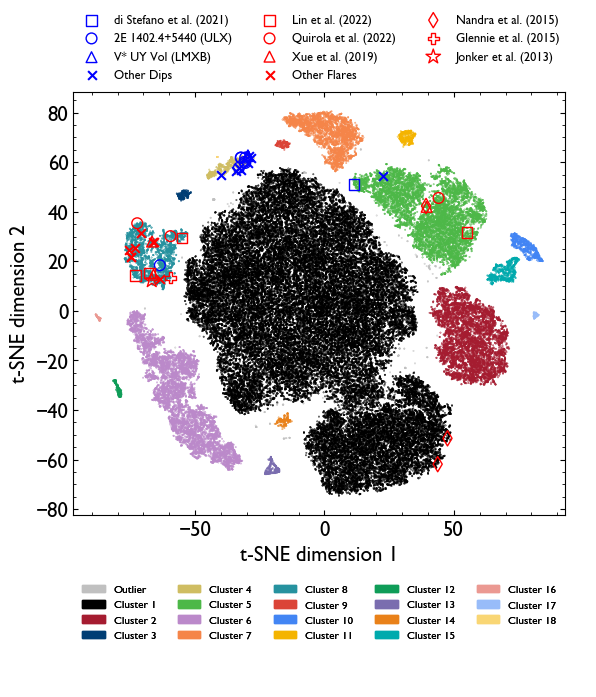

In [6]:
# PLOT
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

imperial = '#003E74'
harvard = '#A51C30'
silver = '#777777'
silver2 = '#C0C0C0'
gold = '#cfbd62'
h_green = "#4db848"
# h_green = "#66A40A"
# h_green = "#205527"

h_orange = "#f58549"
h_purple = "#bb89ca"
h_turq = "#00aaad"
# gold = '#dfc16d'

# Define Colour Scheme
google_blue = '#4285F4'
google_red = '#DB4437'
google_yellow = '#F4B400'
google_green = '#0F9D58'
google_purple = '#7A6DAF'
google_orange = '#E98119' ##EB8B14
google_turq = '#26929F'
light_blue = '#98BCF9'
light_red = '#EB9992'
light_yellow = '#F9D674'
light_green = '#7CCAA4'
light_purple = '#B6AFD3'
light_orange = '#F3BA82'
light_turq = '#89C4CB'
dark_blue = '#244985'
dark_red = '#8B2B23'
dark_yellow = '#B18300'
dark_green = '#0A6438'
dark_purple = '#4E456F'
dark_orange = '#945210' 
dark_turq = '#185D65'
grey_blue = '#5A7FBB'
grey_red = '#AE5B54'
grey_yellow = '#BB9836'
grey_green = '#3E8C66'
grey_purple = '#787290'
grey_orange = '#B57C44'
grey_turq = '#4B868D'


colors = [silver2,'black',harvard,imperial,gold,h_green,h_purple,h_turq,google_red,google_blue,google_yellow,google_green,google_purple,google_orange,google_turq, light_red, light_blue,light_yellow, light_green, light_purple, light_orange, light_turq, dark_red,dark_blue, dark_yellow, dark_green, dark_purple, dark_orange, dark_turq]
colors = [silver2,'black',harvard,imperial,h_green,gold,h_purple,h_turq,google_red,google_blue,google_green,google_yellow,google_purple,google_orange,google_turq, light_red, light_blue,light_green,light_yellow,  light_purple, light_orange, light_turq, dark_red,dark_blue,  dark_green,dark_yellow, dark_purple, dark_orange, dark_turq]
colors = [silver2,'black',harvard,imperial,gold,h_green,h_purple,h_orange,google_turq,google_red,google_blue,google_yellow,google_green,google_purple,google_orange,h_turq, light_red, light_blue,light_yellow,light_green,  light_purple, light_orange, light_turq, dark_red,dark_blue, dark_yellow,  dark_green, dark_purple, dark_orange, dark_turq, 'red', 'blue', 'yellow', 'green', 'orange', 'magenta','cyan','brown','navy','gold','forestgreen']
# colors = ['black',harvard,imperial,gold,h_green,h_purple,h_orange,google_turq,google_red,google_blue,google_yellow,google_green,google_purple,google_orange,h_turq, light_red, light_blue,light_yellow,light_green,  light_purple, light_orange, light_turq, dark_red,dark_blue, dark_yellow,  dark_green, dark_purple, dark_orange, dark_turq, 'red', 'blue', 'yellow', 'green', 'orange', 'magenta','cyan','brown','navy','gold','forestgreen']

cmap = ListedColormap(colors[:len(df_tsne['cluster'].unique())])
# cmap = plt.get_cmap('tab20b', len)

# Create custom legend handles for clusters
unique_labels = df_tsne['cluster'].unique()
print(unique_labels)
cluster_legend_handles = []
for i in range(len(unique_labels)):
    if i > 0:
        label = 'Cluster ' + str(unique_labels[i]+1)
        color = colors[i % len(colors)]
        cluster_legend_handles.append(mpatches.Patch(color=color, label=label))
    else:
        label = 'Outlier'
        color = colors[i % len(colors)]
        cluster_legend_handles.append(mpatches.Patch(color=color, label=label))

# Define Font Settings
plt.rcParams.update({'font.size': 15})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Gill Sans'
fig, axs = plt.subplots(figsize=(6, 6),tight_layout = True)
plt.subplots_adjust(bottom=0.5, right=1, top=1)

cluster = axs.scatter(df_tsne['tsne1'], df_tsne['tsne2'], s=0.1, c=df_tsne['cluster'], cmap=cmap)
axs.set_xlabel('t-SNE dimension 1')
axs.set_ylabel('t-SNE dimension 2')

markersize = 40
c_f = 'red'
c_d = 'blue'

axs.scatter(tsne_distefano['tsne1'], tsne_distefano['tsne2'], edgecolors=c_d, marker='s', s=markersize*1.5, facecolor='none', label='di Stefano et al. (2021)')
axs.scatter(tsne_m101ulx['tsne1'], tsne_m101ulx['tsne2'], edgecolors=c_d, marker='o', s=markersize*1.5, facecolor='none', label='2E 1402.4+5440 (ULX)')
axs.scatter(tsne_parmar['tsne1'], tsne_parmar['tsne2'], edgecolors=c_d, marker='^', s=markersize*1.5, facecolor='none', label='V* UY Vol (LMXB)')
axs.scatter(tsne_moredips['tsne1'], tsne_moredips['tsne2'], c=c_d, marker='x', s=markersize*1, facecolor='none', label='Other Dips')
 
axs.scatter(tsne_lin['tsne1'], tsne_lin['tsne2'], edgecolors=c_f, marker='s', s=markersize*1.5, facecolor='none', label='Lin et al. (2022)')
axs.scatter(tsne_vasquez['tsne1'], tsne_vasquez['tsne2'], edgecolors=c_f, marker='o', s=markersize*1.5, facecolors='none', label='Quirola et al. (2022)')
axs.scatter(tsne_xue['tsne1'], tsne_xue['tsne2'], edgecolors=c_f, marker='^', s=markersize*1.5, facecolor='none', label='Xue et al. (2019)')
axs.scatter(tsne_flares['tsne1'], tsne_flares['tsne2'], c=c_f, marker='x', s=markersize*1, facecolor='none', label='Other Flares')
axs.scatter(tsne_nandra['tsne1'], tsne_nandra['tsne2'], edgecolors=c_f, marker='d', s=markersize*1.5, facecolor='none', label='Nandra et al. (2015)')
axs.scatter(tsne_glennie['tsne1'], tsne_glennie['tsne2'], edgecolors=c_f, marker='P', s=markersize*1.5, facecolor='none', label='Glennie et al. (2015)')
axs.scatter(tsne_jonker['tsne1'], tsne_jonker['tsne2'], edgecolors=c_f, marker='*', s=markersize*3, facecolor='none', label='Jonker et al. (2013)')


# axs.scatter(tsne_new['tsne1'], tsne_new['tsne2'], c='magenta', marker='X', s=markersize*5, facecolor='none', label='NEW')


axs.grid(False) 
axs.minorticks_on()
axs.tick_params(which='both', direction='in', top=True, right=True)
anomaly_legend = axs.legend(loc='upper center', bbox_to_anchor=(0.5, 1.21),
          ncol=3, frameon = False,fontsize=9)
# axs.legend(loc='upper right', bbox_to_anchor=(1., 1),frameon = False,fontsize=12)
# plt.tight_layout()




# axs.set_title(dbscan_file)
axs.set_title('ccdfdftverjrvennkkbhnbnhkhhhjhhhhkhkvkh;vdbgb \n ccdfdftvevkervwrbgb \n weqgf1wqrger',c='white', loc='left')
# Combine both legends into a single legend
cluster_legend = axs.legend(handles=cluster_legend_handles, bbox_to_anchor=(0.5, -0.39), loc='lower center', ncol=5, frameon = False,fontsize=8) # 3D pca 
cluster_legend = axs.legend(handles=cluster_legend_handles, bbox_to_anchor=(0.5, -0.5), loc='lower center', ncol=5, frameon = False,fontsize=8) # 2D pca

cluster_legend = axs.legend(handles=cluster_legend_handles, bbox_to_anchor=(0.5, -0.43), loc='lower center', ncol=5, frameon = False,fontsize=8) # 2D xae
cluster_legend = axs.legend(handles=cluster_legend_handles, bbox_to_anchor=(0.5, -0.32), loc='lower center', ncol=5, frameon = False,fontsize=8) # 3D xae

# plt.figtext(0.5, -0.23, "one text and next text", ha="center", fontsize=10, bbox={"facecolor":"white", "alpha":0.0, "pad":30, "edgecolor":"white"}, c='white') # pca
plt.figtext(0.5, -0.16, "one text and next text", ha="left", fontsize=10, bbox={"facecolor":"white", "alpha":0.0, "pad":30, "edgecolor":"white"}, c='white')  #xae

# Add both legends to the plot
axs.add_artist(cluster_legend)
axs.add_artist(anomaly_legend)

plt.show()


Box

-76.826416 -27.031042


Text(0, 0.5, 'tSNE feature 2')

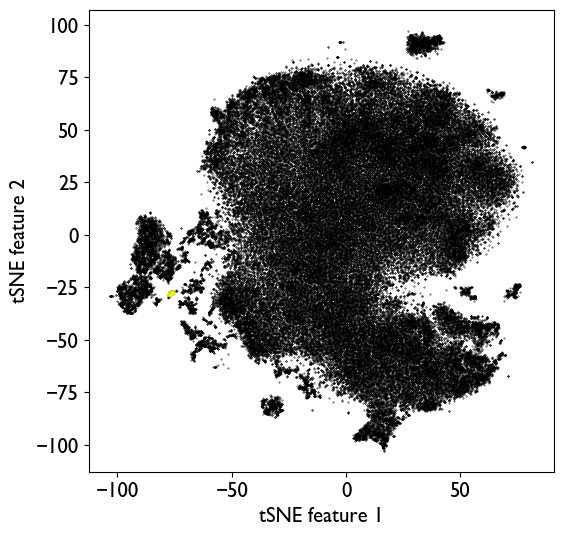

In [13]:
box_size = 2

# box = anomalies[anomalies['obsreg_id']=='17743_278']
box = df_tsne[df_tsne['obsreg_id']=='803_90']
x0, y0 = box[['tsne1']].values[0][0], box[['tsne2']].values[0][0]
print(x0, y0)
xmin, xmax = x0 - box_size, x0 + box_size
ymin, ymax = y0 - box_size, y0 + box_size
points_in_box = df_tsne[(df_tsne['tsne1'] >= xmin) & (df_tsne['tsne1'] <= xmax) & (df_tsne['tsne2'] >= ymin) & (df_tsne['tsne2'] <= ymax)]
potential_anomalies2 = points_in_box['obsreg_id']
df_properties_anomalies2 = df_properties_global[df_properties_global['obsreg_id'].isin(potential_anomalies2)]

fig, axs = plt.subplots(1, 1, figsize=(6, 6))
plt.rcParams.update({'font.size': 15})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Gill Sans'
rej = axs.scatter(df_tsne['tsne1'], df_tsne['tsne2'], s=0.1, c='black', label = 'Rejected Clusters')
acc = axs.scatter(points_in_box['tsne1'], points_in_box['tsne2'], s=0.1, c='yellow', label = 'Chosen Clusters')
axs.set_xlabel('tSNE feature 1')
axs.set_ylabel('tSNE feature 2')
# axs.set_title(dbscan_file)

Cluster

In [231]:
print(soft_indices)
print(hard_indices)
print(v_indices)

[7, 13]
[2, 4, 12]
[3, 4, 6, 10, 11, 14, 15, 17, 18, 19, 21, 22, 24, 26]


3802
Potential Dips:  685
Potential Flares:  3117
Potential Dips:  0
Potential Flares:  0


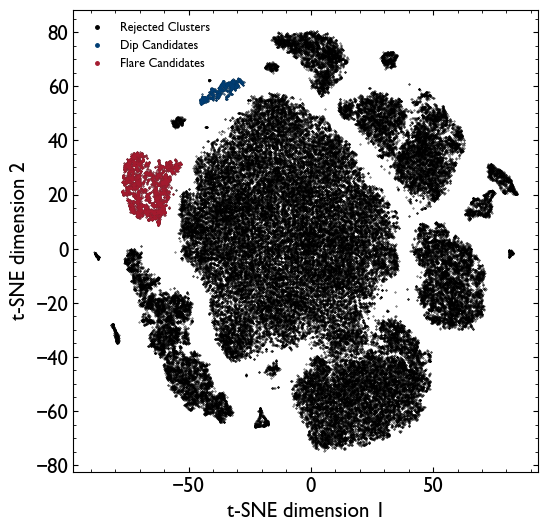

In [7]:
# PCA 3D
clust_flare = [3, 4, 6, 10, 11, 14, 15, 17, 18, 19, 21, 22, 24, 26] #3d pca flares
clust_dip = [5] #3d pca dips
clust_hard = [] #3d pca hard
clust_soft = [] #3d pca soft

# #PCA 2D
# clust_flare = [] #2d xae flares
# clust_dip = [] #2d xae dips
# clust_hard = hard_indices # [11,5,22,19,2,23,36,29,31,38] #2d xae hard
# clust_soft = soft_indices #[7,14,34,8,13,27,21,35,20,32,17,16,30,15] #2d xae soft

#AE 3D
clust_flare = [8] #3d xae flares
clust_dip = [4] #3d xae dips
clust_hard = [] #3d xae hard
clust_soft = [] #3d xae soft

# #AE 2D
# clust_flare = [] #2d xae flares
# clust_dip = [] #2d xae dips
# clust_hard = hard_indices # [4,18,21,30,28,3,28,23,25,26,27,29] #2d xae hard
# clust_soft = soft_indices # [7,2,19,10,5,14,20,16] #2d xae soft

# #RANDOM
# clust_flare = [18] #3d xae flares
# clust_dip = [] #3d xae dips
# clust_hard = [] #3d xae hard
# clust_soft = [] #3d xae soft


# clust = [20] #3d pca flares
select_clusters = [num - 1 for num in clust_flare + clust_dip +  clust_hard + clust_soft]                   
select_clusters_flare = [num - 1 for num in clust_flare]
select_clusters_dip = [num - 1 for num in clust_dip]
select_clusters_hard = [num - 1 for num in clust_hard]
select_clusters_soft = [num - 1 for num in clust_soft]
df_select = df_tsne[df_tsne['cluster'].isin(select_clusters)]
df_select_f = df_tsne[df_tsne['cluster'].isin(select_clusters_flare)]
df_select_d = df_tsne[df_tsne['cluster'].isin(select_clusters_dip)]
df_select_h = df_tsne[df_tsne['cluster'].isin(select_clusters_hard)]
df_select_s = df_tsne[df_tsne['cluster'].isin(select_clusters_soft)]
# df_select = df_tsne[~df_tsne['cluster'].isin(select_clusters)]
potential_anomalies = df_select['obsreg_id']
potential_dips = df_select_d['obsreg_id']
potential_flares = df_select_f['obsreg_id']
potential_hard = df_select_h['obsreg_id']
potential_soft = df_select_s['obsreg_id']

df_properties_anomalies = df_properties_global[df_properties_global['obsreg_id'].isin(potential_anomalies)]

# df_properties_anomalies  = df_properties_anomalies[df_properties_anomalies['var_prob_b'] > 0.5]
# df_select = df_select[(df_select['tsne1'] >= 65) & (df_select['tsne1'] <= 69) & (df_select['tsne2'] >= -6) & (df_select['tsne2'] <= -5)]

# df_properties_anomalies.head(500)
# 67.453880	-5.705921	4062_31	3
# df_select = df_select[(df_select['tsne1'] >= 90) & (df_select['tsne1'] <= 95) & (df_select['tsne2'] >= 0.5) & (df_select['tsne2'] <= 1)]


fig, axs = plt.subplots(1, 1, figsize=(6, 6))
plt.rcParams.update({'font.size': 15})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Gill Sans'
rej = axs.scatter(df_tsne['tsne1'], df_tsne['tsne2'], s=0.1, c='black', label = 'Rejected Clusters')
# acc = axs.scatter(df_select['tsne1'], df_select['tsne2'], s=0.1, c=harvard, label = 'Chosen Clusters')
acc = axs.scatter(df_select_d['tsne1'], df_select_d['tsne2'], s=0.1, c=imperial, label = 'Dip Clusters')
acc = axs.scatter(df_select_f['tsne1'], df_select_f['tsne2'], s=0.1, c=harvard, label = 'Flare Clusters')
# acc = axs.scatter(df_select_s['tsne1'], df_select_s['tsne2'], s=0.1, c=silver2, label = 'Soft Clusters')
# acc = axs.scatter(df_select_h['tsne1'], df_select_h['tsne2'], s=0.1, c=gold, label = 'Hard Clusters')
axs.set_xlabel('t-SNE dimension 1')
axs.set_ylabel('t-SNE dimension 2')
axs.grid(False) 
axs.minorticks_on()
axs.tick_params(which='both', direction='in', top=True, right=True)
# axs.set_title(dbscan_file)
custom_markers = [plt.scatter([], [], marker='.', color='black', edgecolor='black', s=25),plt.scatter([], [], marker='.', color=silver2, edgecolor=silver2, s=25),plt.scatter([], [], marker='.', color=gold, edgecolor=gold, s=25)]
custom_markers = [plt.scatter([], [], marker='.', color='black', edgecolor='black', s=25),plt.scatter([], [], marker='.', color=imperial, edgecolor=imperial, s=25),plt.scatter([], [], marker='.', color=harvard, edgecolor=harvard, s=25)]
legend = axs.legend(handles=custom_markers, labels=['Rejected Clusters','Dip Candidates', 'Flare Candidates', 'Hard Clusters', 'Soft Clusters'], loc='upper left', frameon=False, fontsize=9)
# legend = axs.legend(handles=custom_markers, labels=['Rejected Clusters','Soft Clusters', 'Hard Clusters'], loc='upper left', frameon=False, fontsize=9)

print(len(potential_anomalies))

dip_ids = list(potential_dips)
print('Potential Dips: ', len(dip_ids))
flare_ids = list(potential_flares)
print('Potential Flares: ', len(flare_ids))
hard_ids = list(potential_hard)
print('Potential Dips: ', len(hard_ids))
soft_ids = list(potential_soft)
print('Potential Flares: ', len(soft_ids))

# with open(f'{global_path}/{set_id}/dips-PCA3D.pkl', 'wb') as f:
#     # Write the list to the file using pickle
#     pickle.dump(dip_ids, f)
# with open(f'{global_path}/{set_id}/flares-PCA3D.pkl', 'wb') as f:
#     # Write the list to the file using pickle
#     pickle.dump(flare_ids, f)

# with open(f'{global_path}/{set_id}/dips-XAE3D.pkl', 'wb') as f:
#     # Write the list to the file using pickle
#     pickle.dump(dip_ids, f)
# with open(f'{global_path}/{set_id}/flares-XAE3D.pkl', 'wb') as f:
#     # Write the list to the file using pickle
#     pickle.dump(flare_ids, f)



In [17]:
# Iterate over the groups in the list
groups_to_keep = select_clusters 
cluster_averages_group = cluster_averages.drop('cluster', axis=1)
grouped = cluster_averages_group.groupby('cluster')
filtered_groups = []
for group in groups_to_keep:
    # Check if the group exists in the grouped DataFrame
    if group in grouped.groups:
        # Retrieve the group from the grouped DataFrame
        filtered_group = grouped.get_group(group)
        # Append the filtered group to the list
        filtered_groups.append(filtered_group)

# Concatenate the filtered groups into a single DataFrame
filtered_df = pd.concat(filtered_groups)
filtered_df = filtered_df.sort_index()
filtered_df

tsne1      tsne2   hard_hm   hard_hs   hard_ms  var_prob_b   
cluster                                                                   
17       53.355981 -27.677553  0.324049  0.407895  0.258539    0.976532  \

         var_prob_h  var_prob_m  var_prob_s  var_index_b  
cluster                                                   
17         0.972715    0.884943    0.769318     8.378531

In [14]:
# 6. Lightcurve Plotter Function
def lightcurveplotterNEW(df_eventfiles_input,id_name,bin_size_sec,hr_window=10,bb_p0 = 0.1,band_errors = True):
    """
    DESCRIPTION: Plots lightcurves and cumulative counts for given eventfile input dataframe
    INPUT: 1. Original eventfile table, 2. Original properties table, 3. Global Path, 4. Set Name
    OUTPUT: 1. Reduced eventfile table, 2. Reduced properties table
    """
    # Define Colour Scheme
    google_blue = '#4285F4'
    google_red = '#DB4437'
    google_yellow = '#F4B400'
    google_green = '#0F9D58'
    google_purple = '#6f2da8'
    # Define Font Settings
    plt.rcParams.update({'font.size': 9})
    plt.rcParams['font.sans-serif'] = 'Helvetica'
    plt.rcParams['font.family'] = 'sans-serif'
    # Create subplots 
    fig, axs = plt.subplots(5, 1, figsize=(6, 12),constrained_layout = True)
    fig.suptitle(f'ObsRegID: {id_name}',fontweight="bold")
    # Prepare df
    df = df_eventfiles_input.copy()
    df['time'] = df_eventfiles_input['time'] - min(df_eventfiles_input['time'])
    df = df.sort_values(by='time') 
    df = df.reset_index(drop=True)
    # Create binned lightcurve
    df_binned = df.groupby(df['time'] // bin_size_sec * bin_size_sec).agg(
        broad_count = ('energy', lambda x: ((x >= 500) & (x <= 7000)).sum()),
        soft_count =('energy', lambda x: ((x >= 500) & (x < 1200)).sum()),
        medium_count=('energy', lambda x: ((x >= 1200) & (x < 2000)).sum()),
        hard_count=('energy', lambda x: ((x >= 2000) & (x <= 7000)).sum()))
    # Plot binned lightcurve
    axs[0].plot(df_binned.index/1000, df_binned['broad_count'], color = google_blue, marker = 'o', markerfacecolor = 'black', markersize = 4)
    axs[0].set_xlabel('Time [ks]')
    axs[0].set_ylabel('Counts per Bin')
    axs[0].set_title(f'Lightcurve with {bin_size_sec}s Bin Size')
    axs[0].set_xlim([0,max(df["time"]/1000)])
    # Create rolling 3-bin averaged lightcurved
    df_rolling = df_binned.rolling(window=3, center=True).mean()
    rolling_std = df_binned.rolling(window=3, center=True).std()
    errors = rolling_std['broad_count']/math.sqrt(3)
    errors.iloc[0] = errors.iloc[0] * math.sqrt(3)/math.sqrt(2)
    errors.iloc[-1] = errors.iloc[-1] * math.sqrt(3)/math.sqrt(2)

    errors_h = rolling_std['hard_count']/math.sqrt(3)
    errors_h.iloc[0] = errors_h.iloc[0] * math.sqrt(3)/math.sqrt(2)
    errors_h.iloc[-1] = errors_h.iloc[-1] * math.sqrt(3)/math.sqrt(2)

    errors_m = rolling_std['medium_count']/math.sqrt(3)
    errors_m.iloc[0] = errors_m.iloc[0] * math.sqrt(3)/math.sqrt(2)
    errors_m.iloc[-1] = errors_m.iloc[-1] * math.sqrt(3)/math.sqrt(2)

    errors_s = rolling_std['soft_count']/math.sqrt(3)
    errors_s.iloc[0] = errors_s.iloc[0] * math.sqrt(3)/math.sqrt(2)
    errors_s.iloc[-1] = errors_s.iloc[-1] * math.sqrt(3)/math.sqrt(2)
    # Plot rolling 3-bin averaged lightcurved
    axs[1].plot(df_rolling.index/1000, df_rolling['broad_count'], color = google_red)
    axs[1].errorbar(df_rolling.index/1000, df_rolling['broad_count'], yerr = errors, xerr = None,fmt ='.',color = "black",linewidth = .5,capsize = 1)
    axs[1].set_xlabel('Time [ks]')
    axs[1].set_ylabel('Counts per Bin')
    axs[1].set_title('Running Average of 3 Bins')
    axs[1].set_xlim([0,max(df["time"]/1000)])
    # Create cumulative count plot
    df_cumulative = df.copy()
    df_cumulative['count'] = 1
    df_cumulative['cumulative_count'] = df_cumulative['count'].cumsum()
    # Create a BB plot
    bb_bins = astropy.stats.bayesian_blocks(df['time'].values/1000, fitness='events',p0 = bb_p0) # p0 = 0.01 or so BASED ON VINAY ! 6?
    bin_widths = bb_bins[1:] - bb_bins[:-1]
    counts, bins =  np.histogram(df['time']/1000, bins=bb_bins)
    countrate = counts/bin_widths 
    bin_centers = (bb_bins[:-1] + bb_bins[1:]) / 2
    axs[3].step(bb_bins, np.append(countrate, countrate[-1]), where='post', color='black')
    axs[3].set_xlim([0,max(df["time"]/1000)])
    # axs[3].set_xlim(axs[1].get_xlim())
    axs[3].set_xlabel('Time [ks]')
    axs[3].set_ylabel('Count Rate')
    axs[3].set_title(f'Bayesian Blocks Count Rate (p0 = {bb_p0})')
    # Create a Energy Band Plot
    axs[2].plot(df_rolling.index/1000, df_rolling['hard_count'], color = google_blue, label='Hard')
    axs[2].plot(df_rolling.index/1000, df_rolling['medium_count'], color = google_green, label='Medium')
    axs[2].plot(df_rolling.index/1000, df_rolling['soft_count'], color = google_red, label='Soft')
    if band_errors == True:
        axs[2].errorbar(df_rolling.index/1000, df_rolling['hard_count'], yerr = errors_h, xerr = None,fmt ='.',color = google_blue,linewidth = 1,capsize = 2)
        axs[2].errorbar(df_rolling.index/1000, df_rolling['medium_count'], yerr = errors_m, xerr = None,fmt ='.',color = google_green,linewidth = 1,capsize = 2)
        axs[2].errorbar(df_rolling.index/1000, df_rolling['soft_count'], yerr = errors_s, xerr = None,fmt ='.',color = google_red,linewidth = 1,capsize = 2)
    axs[2].set_xlim([0,max(df_binned.index/1000)])
    # axs[3].set_ylim([0,np.max([df_binned['hard_count'],df_binned['medium_count'],df_binned['soft_count']])*1.3])
    axs[2].set_ylabel('Counts')
    axs[2].set_xlabel('Time [ks]')
    axs[2].set_title(f'Energy Bands with {bin_size_sec}s Bin Size - Running Avg')
    axs[2].legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),ncol=3, frameon = False)

    # # Create HR 
    # # Compute the counts for each energy band
    # df['soft_count'] = ((df['energy'] >= 500) & (df['energy'] < 1200)).rolling(hr_window).sum()
    # df['medium_count'] = ((df['energy'] >= 1200) & (df['energy'] < 2000)).rolling(hr_window).sum()
    # df['hard_count'] = ((df['energy'] >= 2000) & (df['energy'] <= 7000)).rolling(hr_window).sum()
    # df[['soft_count', 'medium_count','hard_count']] = df[['soft_count', 'medium_count','hard_count']].shift(-math.floor(hr_window/2))
    # # Compute the HR ratios using the counts
    # df['HR_hs'] = (df['hard_count'] - df['soft_count']) / (df['hard_count'] + df['soft_count'])
    # df['HR_hm'] = (df['hard_count'] - df['medium_count']) / (df['hard_count'] + df['medium_count'])
    # df['HR_ms'] = (df['medium_count'] - df['soft_count']) / (df['medium_count'] + df['soft_count'])

    # axs[4].plot(df["time"]/1000, df['HR_hs'], color = google_blue, label='H-S')
    # axs[4].plot(df["time"]/1000, df['HR_hm'], color = google_green, label='H-M')
    # axs[4].plot(df["time"]/1000, df['HR_ms'], color = google_red, label='M-S')
    # axs[4].set_xlim([0,max(df["time"]/1000)])
    # # axs[3].set_ylim([0,np.max([df_binned['hard_count'],df_binned['medium_count'],df_binned['soft_count']])*1.3])
    # axs[4].set_ylabel('HR')
    # axs[4].set_xlabel('Time [ks]')
    # axs[4].set_title(f'Running HR over {hr_window} counts')
    # axs[4].legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),ncol=3, frameon = False)

    #Create BB HR
    df_hr_bb = df.copy()
    # compute photon counts in each bin
    df_hr_bb = df_hr_bb.groupby(pd.cut(df_hr_bb['time']/1000, bb_bins)).agg(
        hard_count=('energy', lambda x: ((x >= 2000) & (x <= 7000)).sum()),
        medium_count=('energy', lambda x: ((x >= 1200) & (x < 2000)).sum()),
        soft_count=('energy', lambda x: ((x >= 500) & (x < 1200)).sum())
    )
    df_hr_bb["bb_hs"] = (df_hr_bb['hard_count'] - df_hr_bb['soft_count']) / (df_hr_bb['hard_count'] + df_hr_bb['soft_count'])
    df_hr_bb["bb_hm"]  = (df_hr_bb['hard_count'] - df_hr_bb['medium_count']) / (df_hr_bb['hard_count'] + df_hr_bb['medium_count'])
    df_hr_bb["bb_ms"]  = (df_hr_bb['medium_count'] - df_hr_bb['soft_count']) / (df_hr_bb['medium_count'] + df_hr_bb['soft_count'])
    bb_hs = df_hr_bb["bb_hs"].values
    bb_hm = df_hr_bb["bb_hm"].values
    bb_ms = df_hr_bb["bb_ms"].values
    axs[4].step(bb_bins, np.append(bb_hs, bb_hs[-1]), where='post',color = google_blue, label='H-S')
    axs[4].step(bb_bins, np.append(bb_hm, bb_hm[-1]), where='post',color = google_green, label='H-M')
    axs[4].step(bb_bins, np.append(bb_ms, bb_ms[-1]), where='post',color = google_red, label='M-S')
    axs[4].set_xlim([0,max(df["time"]/1000)])
    # axs[5].set_xlim(axs[1].get_xlim())
    axs[4].set_ylabel('HR')
    axs[4].set_xlabel('Time [ks]')
    axs[4].set_title(f'Bayesian Blocks HR')
    axs[4].legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),ncol=3, frameon = False)
    plt.show()
    return countrate 


Lightcurves

In [18]:
variability = df_properties_anomalies[df_properties_anomalies['var_index_b']>5]
print('var', len(variability)/len(df_properties_anomalies)*100, '%')

var 94.9438202247191 %


30
Name: 2CXO J103529.3-581224, ID: 16648-155, Date: 2015-10-07T10:42:32, Counts: 63
RA  158.87230129233876 DEC  -58.20672747332427
varB  1.0 varH  1.0 varM  1.0 varS  0.79 varINDEX  9.0


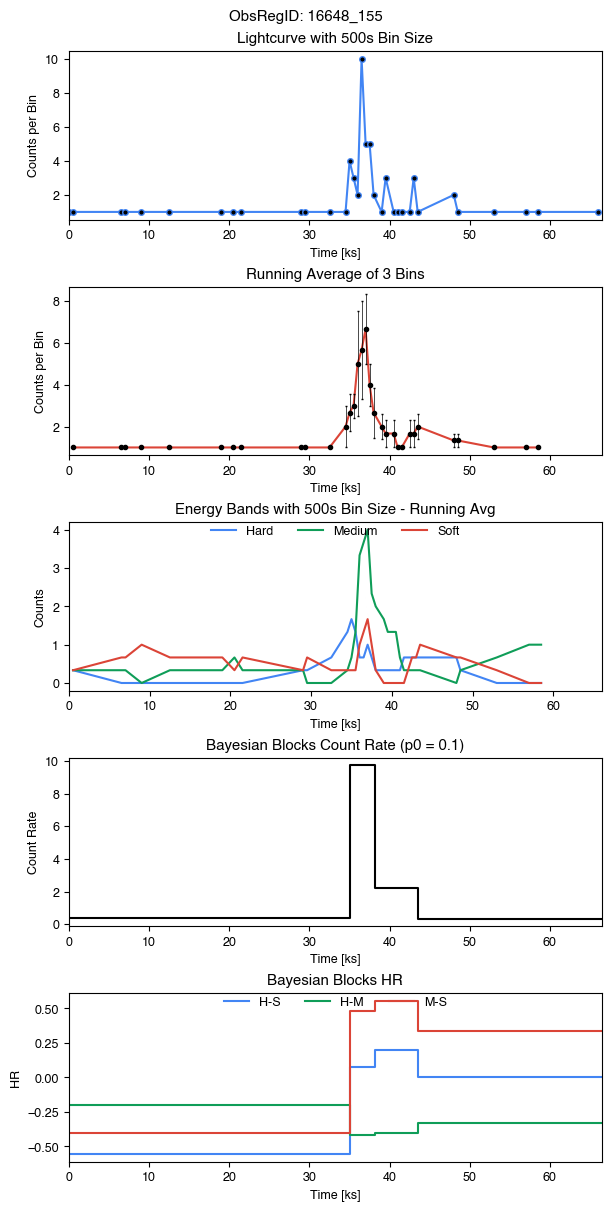

Name: 2CXO J103547.0-581222, ID: 16648-157, Date: 2015-10-07T10:42:32, Counts: 62
RA  158.9461130490472 DEC  -58.206111724380754
varB  1.0 varH  1.0 varM  1.0 varS  1.0 varINDEX  9.0


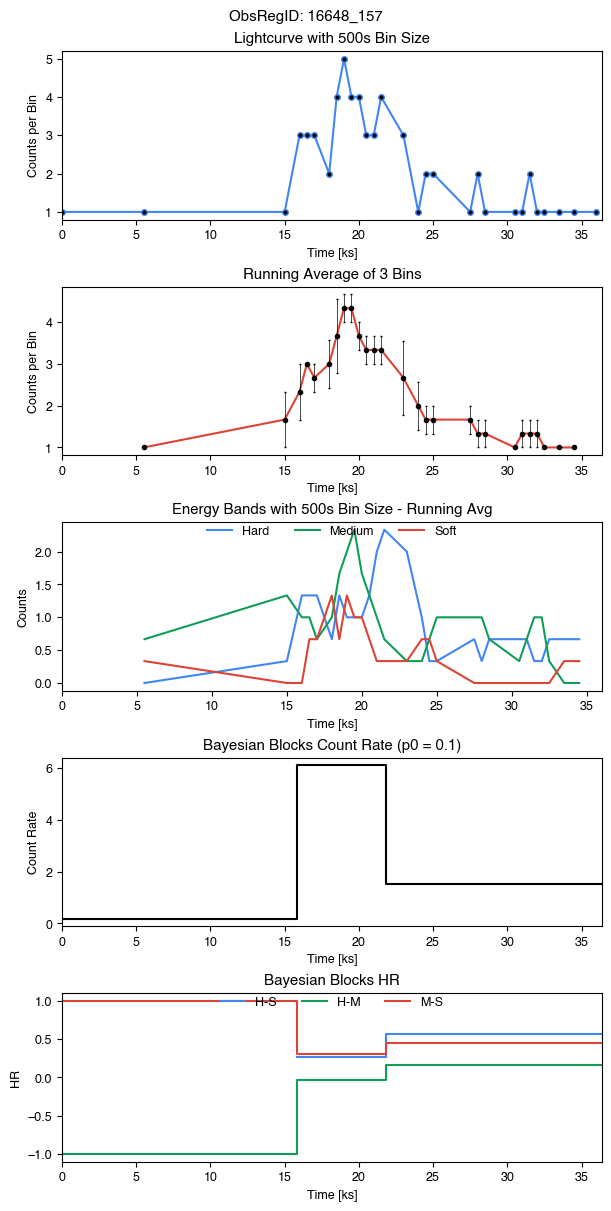

Name: 2CXO J104538.0-594754, ID: 16945-66, Date: 2015-11-28T21:38:40, Counts: 108
RA  161.40828212760437 DEC  -59.79876415153858
varB  1.0 varH  1.0 varM  0.95 varS  nan varINDEX  9.0


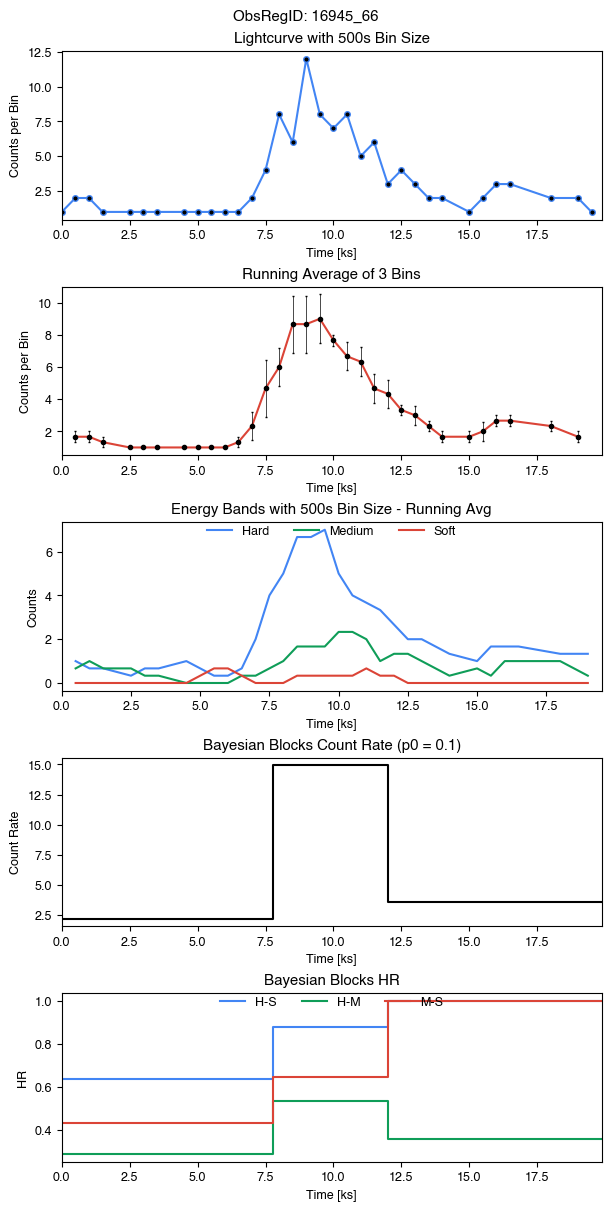

Name: 2CXO J034631.1+240702, ID: 17250-68, Date: 2015-03-27T06:14:50, Counts: 219
RA  56.62996703813605 DEC  24.11720678941458
varB  1.0 varH  0.98 varM  1.0 varS  0.25 varINDEX  7.0


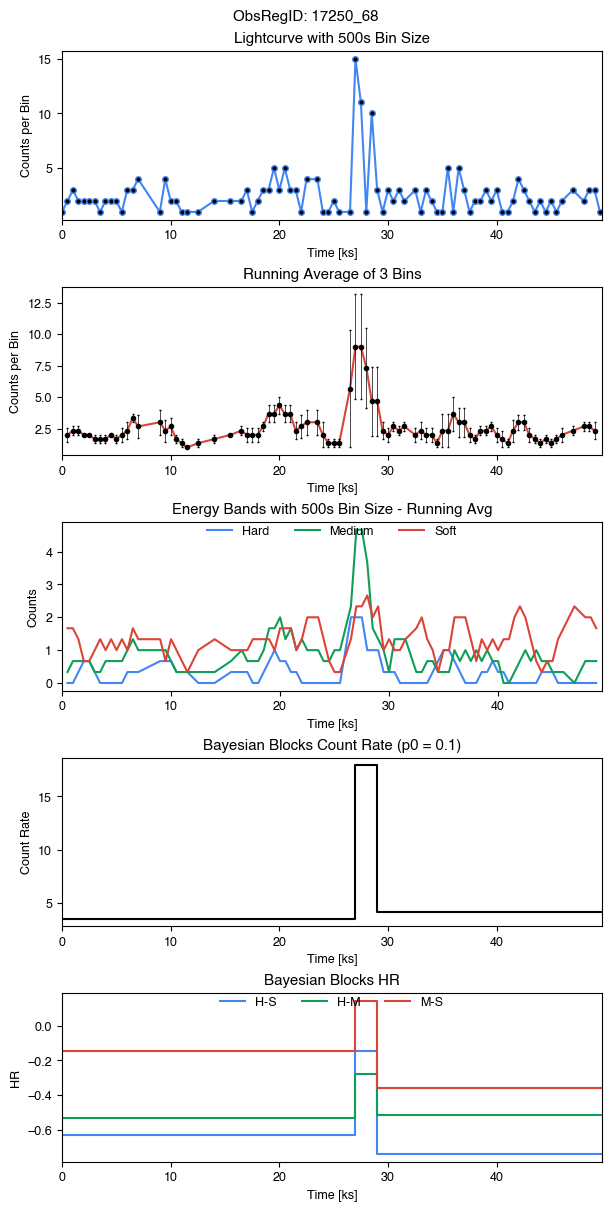

Name: 2CXO J115108.7-280237, ID: 17494-14, Date: 2015-08-17T18:29:57, Counts: 103
RA  177.7863149679256 DEC  -28.043806743110594
varB  1.0 varH  1.0 varM  1.0 varS  1.0 varINDEX  9.0


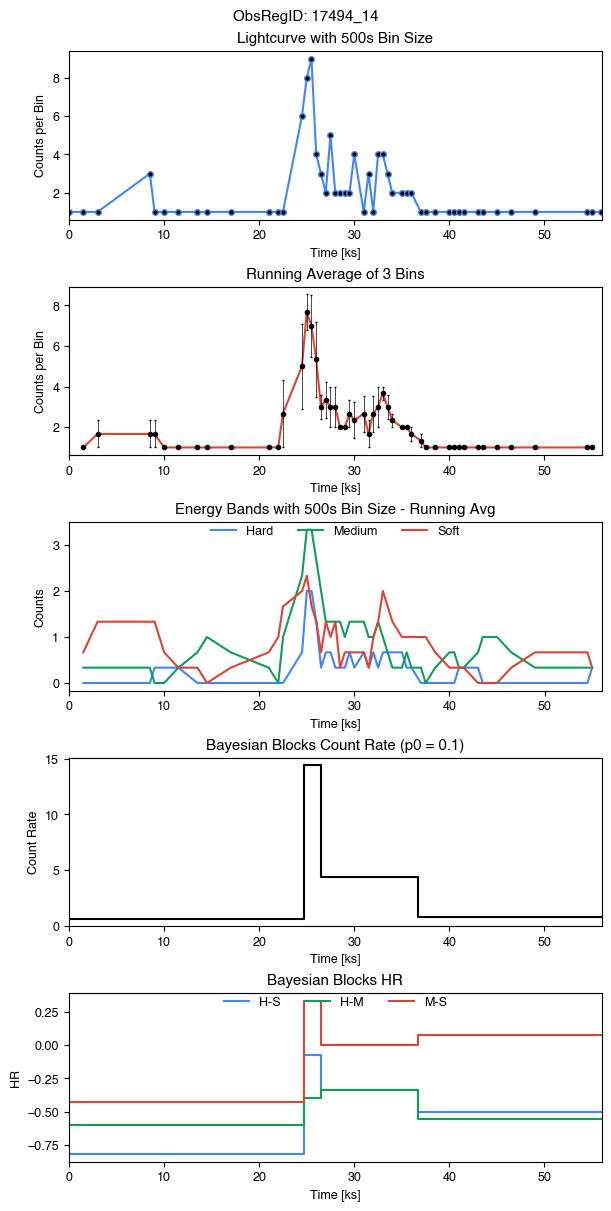

Name: 2CXO J195859.1+404511, ID: 17528-67, Date: 2015-08-30T09:11:18, Counts: 79
RA  299.74638191019426 DEC  40.75306126225261
varB  1.0 varH  0.93 varM  1.0 varS  1.0 varINDEX  9.0


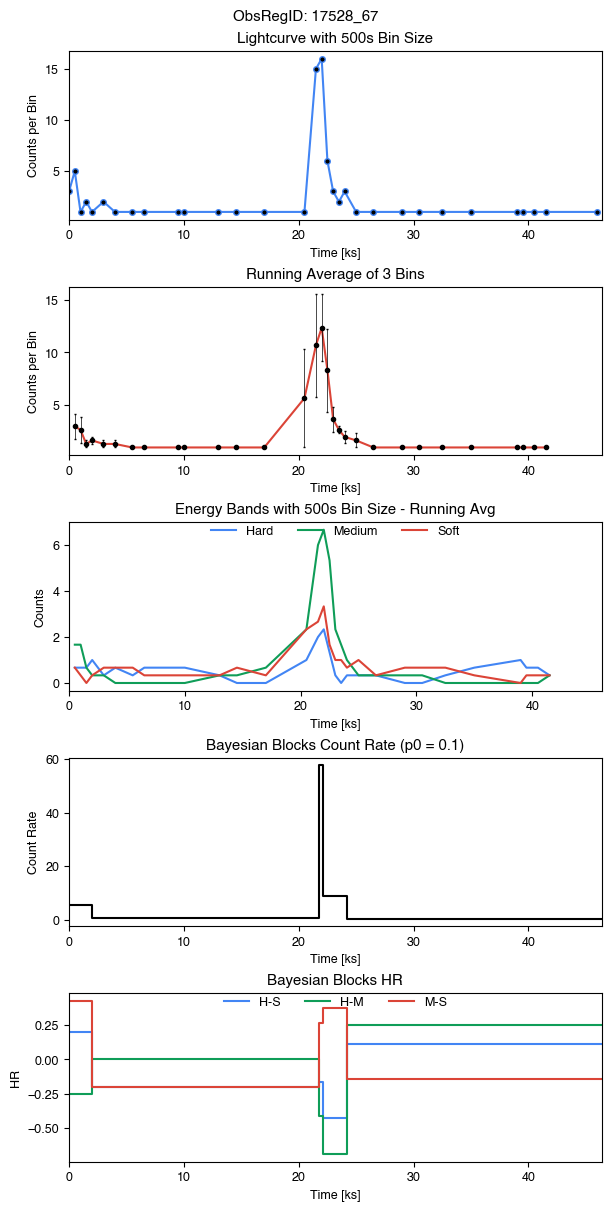

Name: 2CXO J085906.9-473102, ID: 17554-518, Date: 2015-08-21T05:30:10, Counts: 244
RA  134.77878718134093 DEC  -47.51729832078328
varB  1.0 varH  1.0 varM  0.5 varS  nan varINDEX  10.0


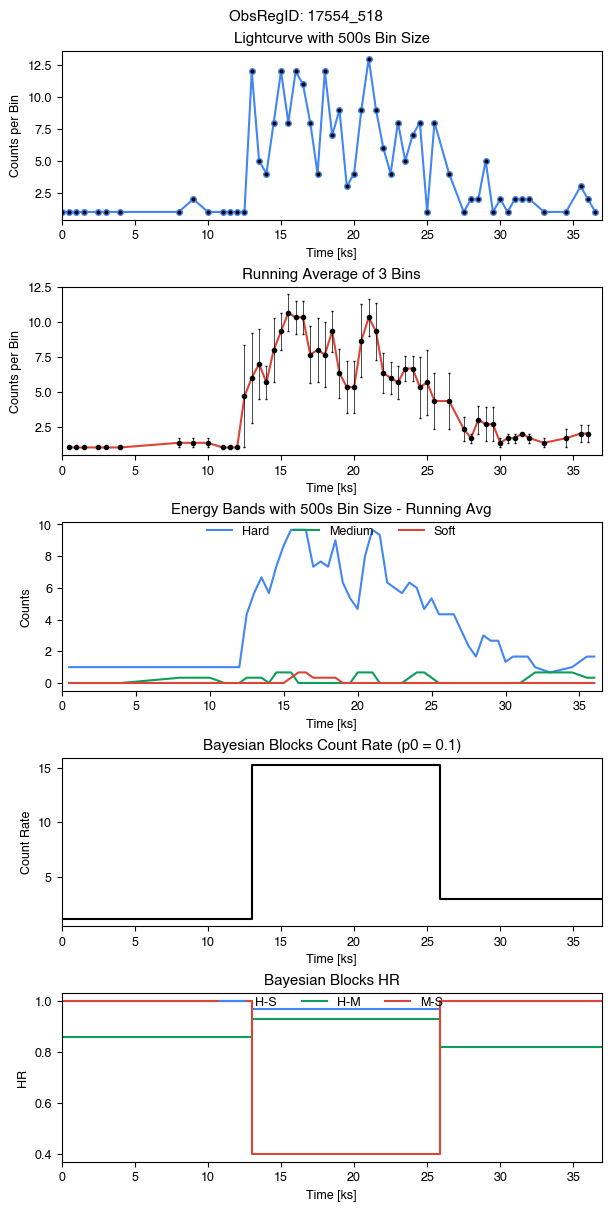

Name: 2CXO J131444.2-162107, ID: 17654-134, Date: 2015-05-10T05:31:08, Counts: 116
RA  198.68448750082007 DEC  -16.351990926164124
varB  1.0 varH  1.0 varM  1.0 varS  1.0 varINDEX  10.0


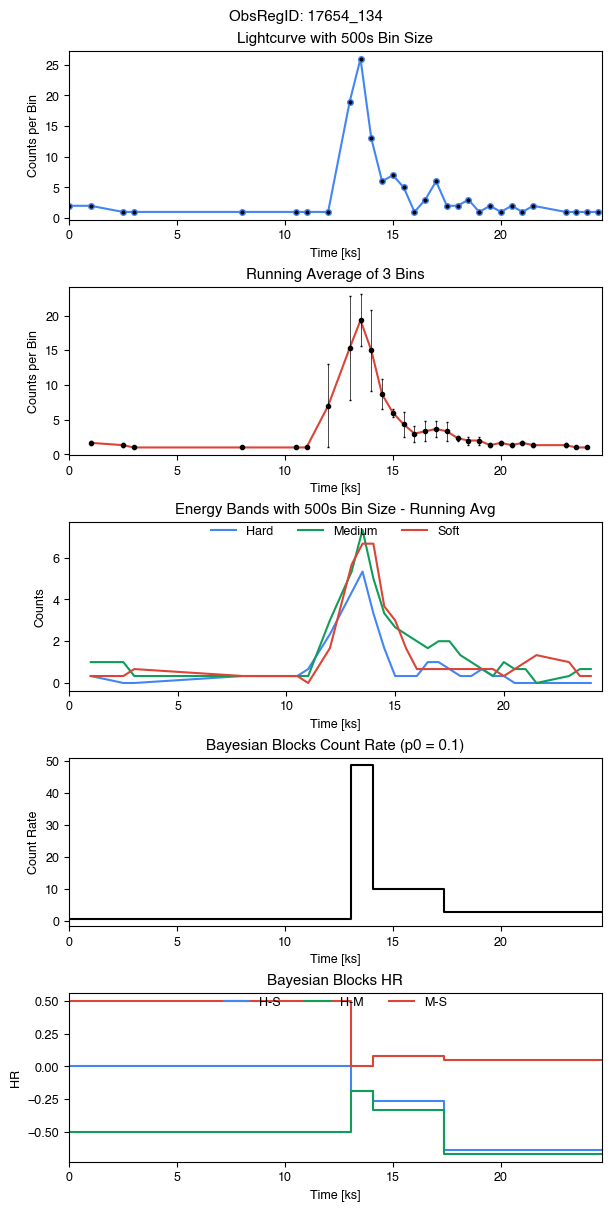

Name: 2CXO J085903.8-473109, ID: 17681-511, Date: 2015-06-15T02:34:12, Counts: 182
RA  134.76624459962738 DEC  -47.51951791002784
varB  1.0 varH  1.0 varM  0.81 varS  nan varINDEX  9.0


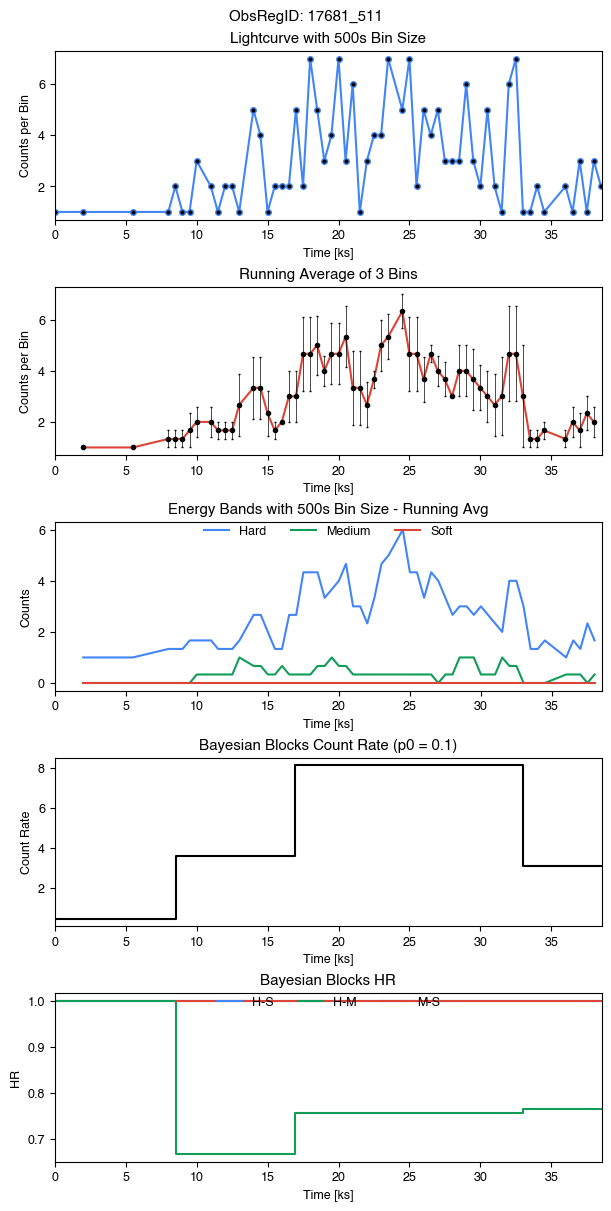

Name: 2CXO J183127.5-020506, ID: 17743-124, Date: 2016-08-01T04:31:31, Counts: 215
RA  277.8646900959236 DEC  -2.085094664221406
varB  1.0 varH  1.0 varM  0.68 varS  0.47 varINDEX  8.0


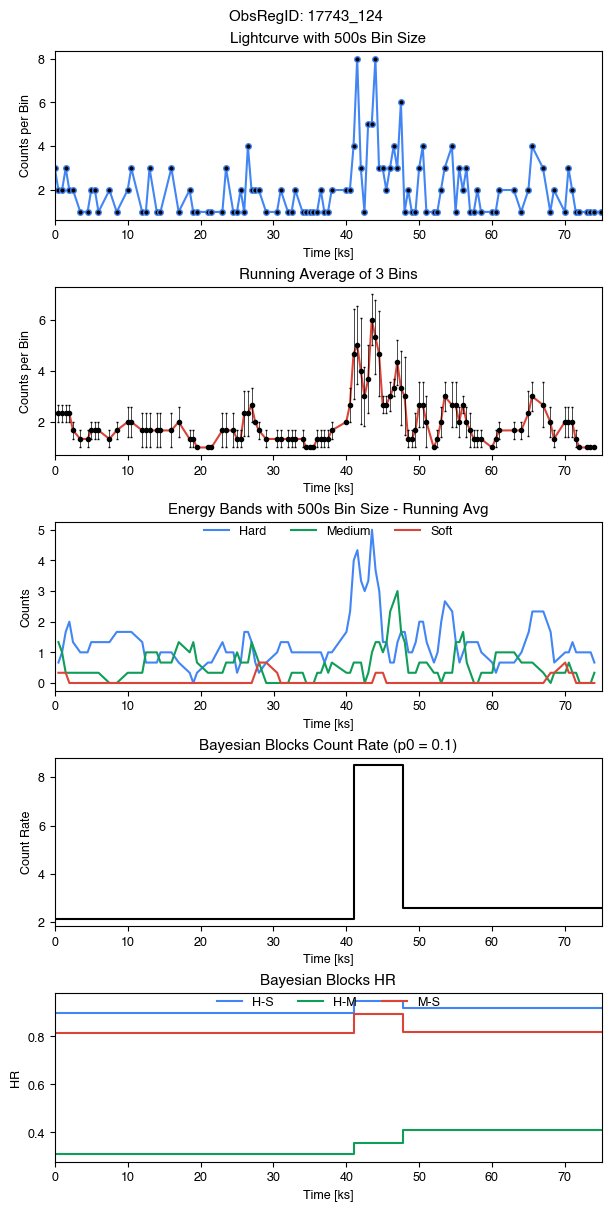

Name: 2CXO J183137.8-020314, ID: 17743-178, Date: 2016-08-01T04:31:31, Counts: 215
RA  277.90751652325514 DEC  -2.0541584461029103
varB  1.0 varH  1.0 varM  1.0 varS  nan varINDEX  10.0


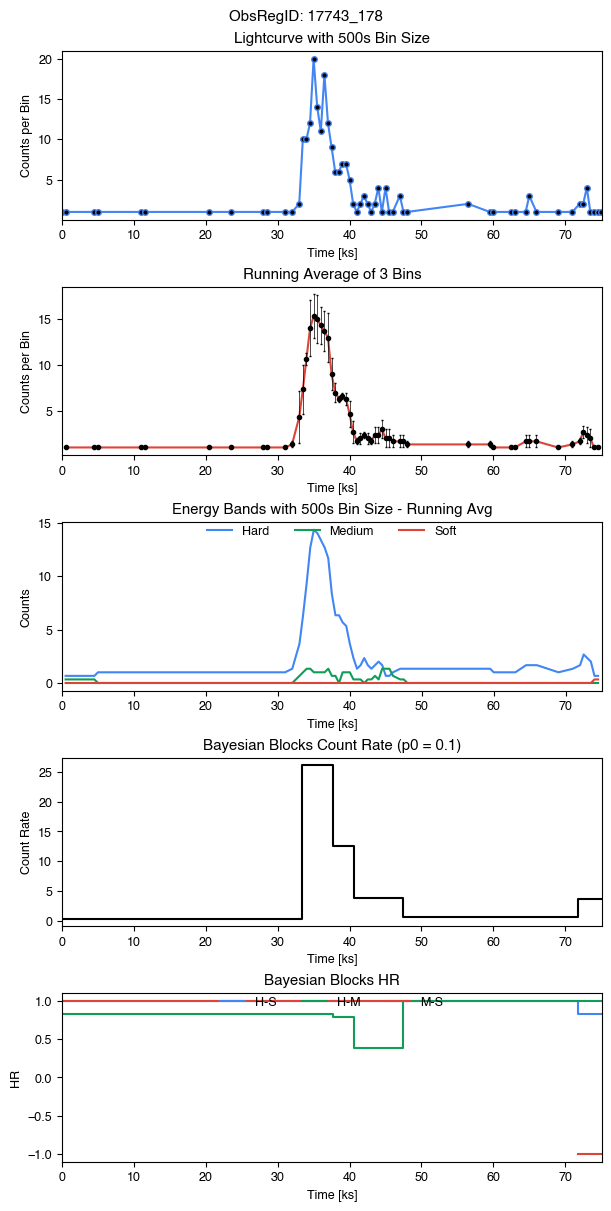

Name: 2CXO J183119.6-020112, ID: 17743-189, Date: 2016-08-01T04:31:31, Counts: 76
RA  277.8321254518787 DEC  -2.01996775916118
varB  1.0 varH  1.0 varM  0.72 varS  nan varINDEX  9.0


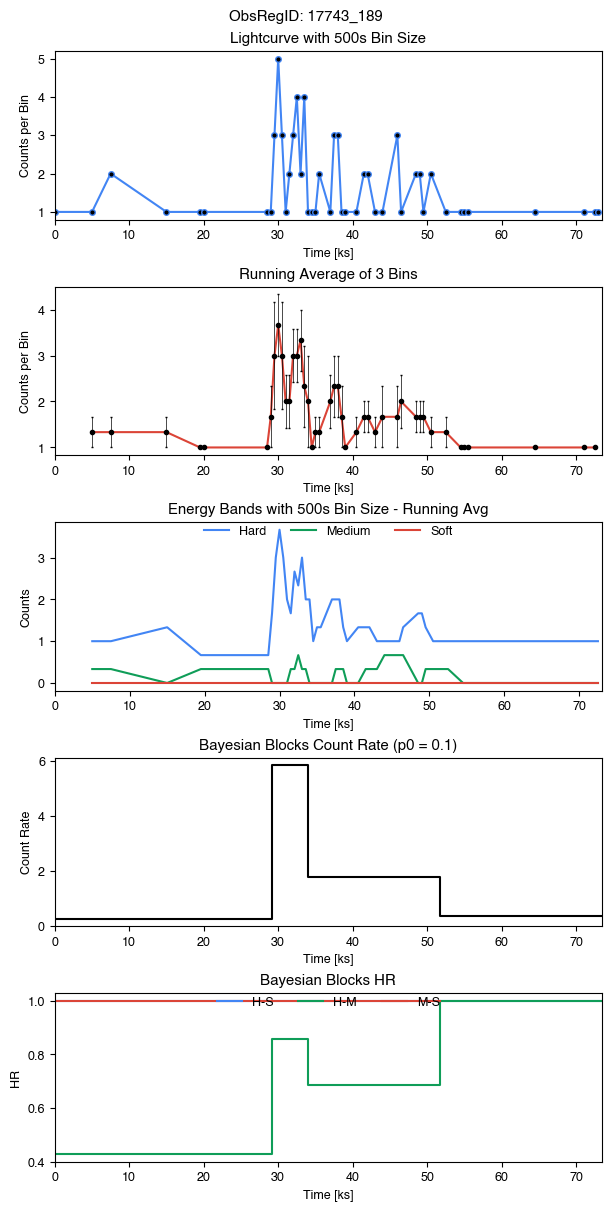

Name: 2CXO J061240.0+175728, ID: 17748-54, Date: 2017-08-13T05:20:25, Counts: 155
RA  93.16719854419244 DEC  17.95823110317254
varB  1.0 varH  1.0 varM  1.0 varS  nan varINDEX  9.0


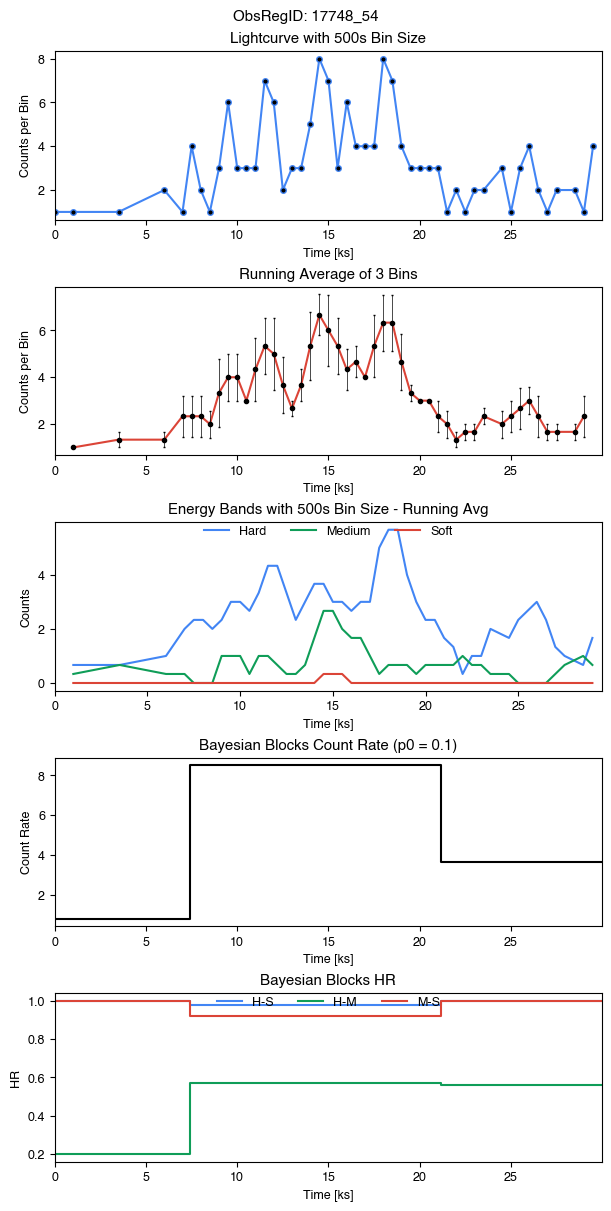

Name: 2CXO J170106.2-460751, ID: 17870-454, Date: 2016-06-22T06:16:25, Counts: 136
RA  255.27612285959592 DEC  -46.13096525465866
varB  1.0 varH  1.0 varM  1.0 varS  0.89 varINDEX  9.0


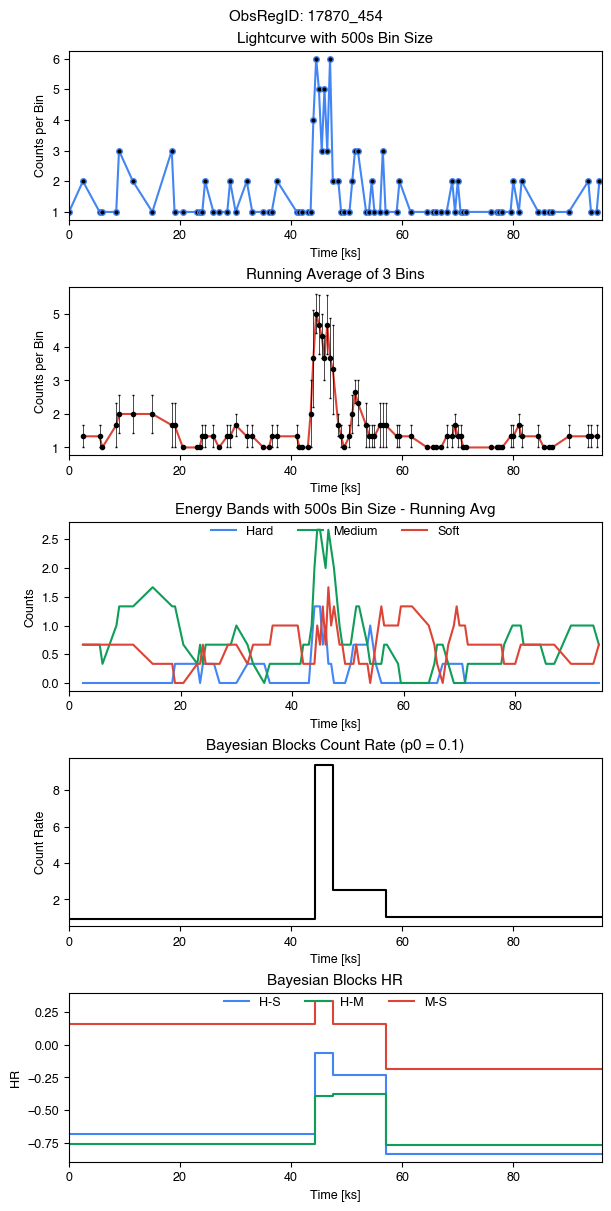

Name: 2CXO J172501.8-341027, ID: 18453-417, Date: 2016-07-05T20:27:41, Counts: 42
RA  261.25771676263207 DEC  -34.174421905568366
varB  1.0 varH  1.0 varM  0.5 varS  nan varINDEX  9.0


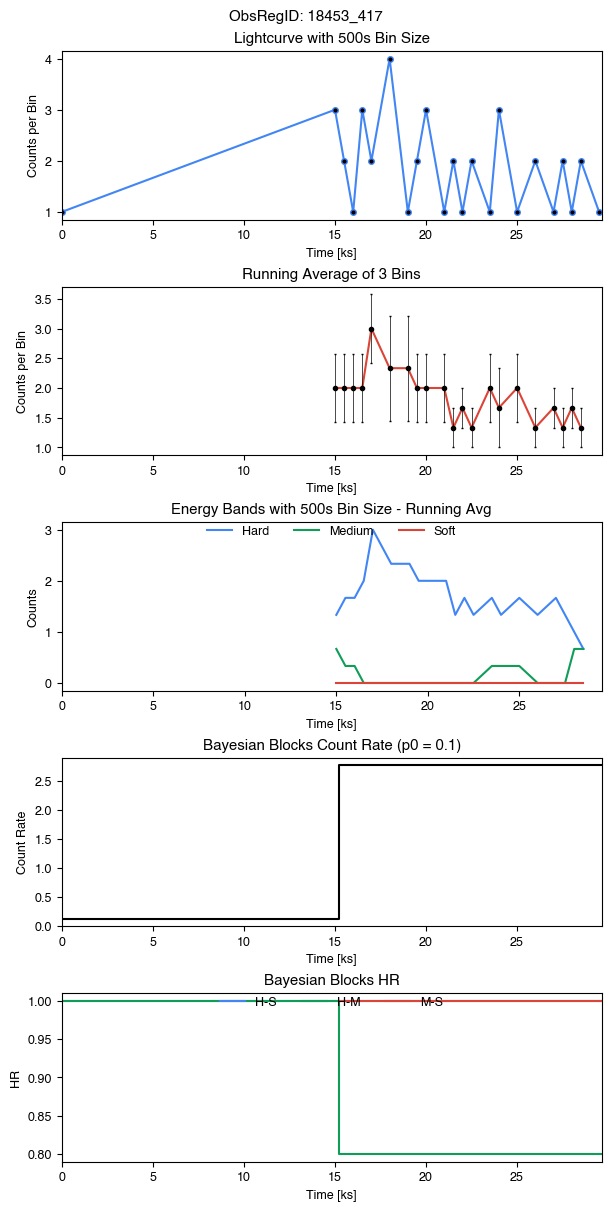

Name: 2CXO J085552.6-463009, ID: 18640-140, Date: 2016-08-30T18:03:17, Counts: 182
RA  133.96784414406147 DEC  -46.50191672467384
varB  0.77 varH  0.91 varM  0.21 varS  nan varINDEX  2.0


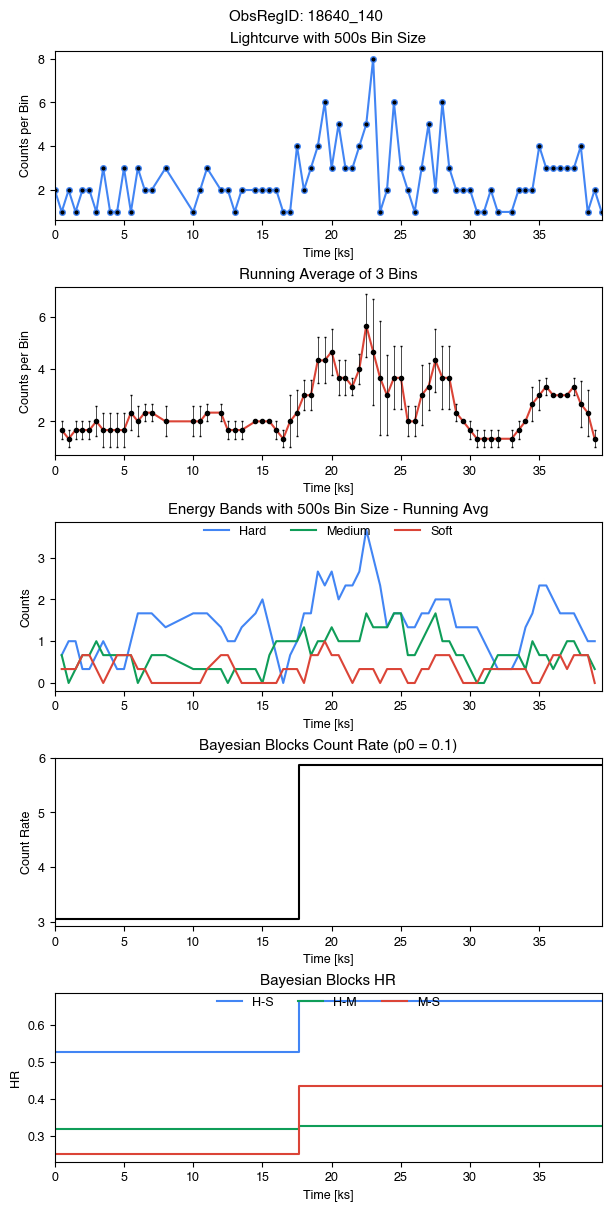

Name: 2CXO J174805.3-244656, ID: 18881-961, Date: 2016-07-15T12:02:34, Counts: 119
RA  267.0224133596769 DEC  -24.782385254487423
varB  1.0 varH  1.0 varM  1.0 varS  nan varINDEX  8.0


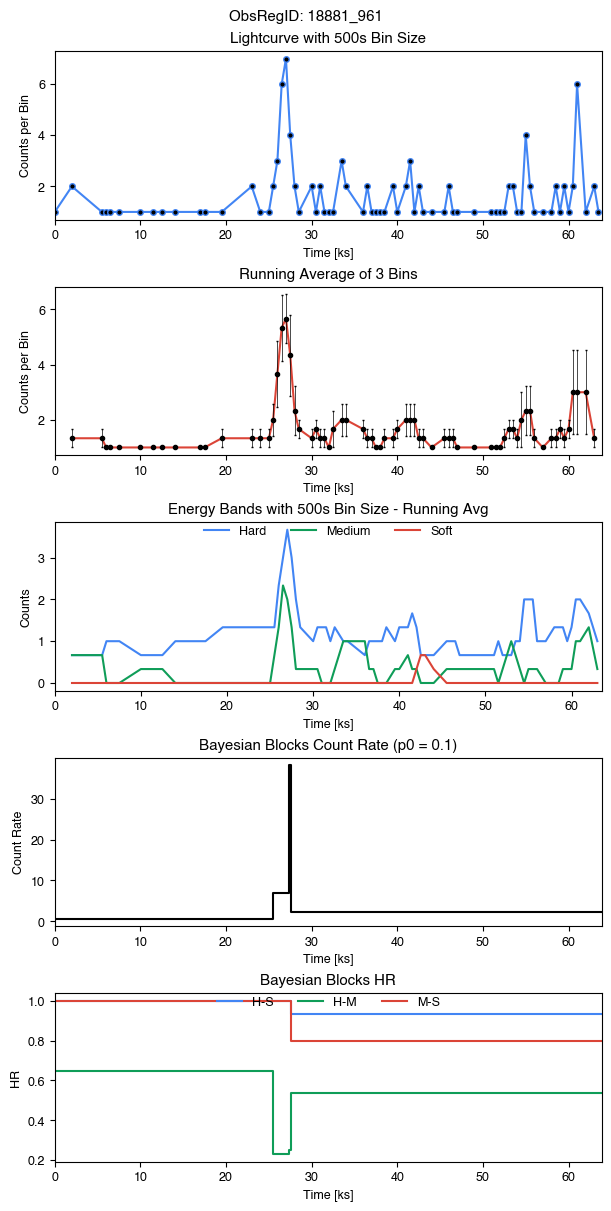

Name: 2CXO J022813.9+613319, ID: 18934-77, Date: 2017-11-25T03:47:47, Counts: 133
RA  37.05817308397684 DEC  61.55536315973897
varB  1.0 varH  1.0 varM  1.0 varS  0.47 varINDEX  9.0


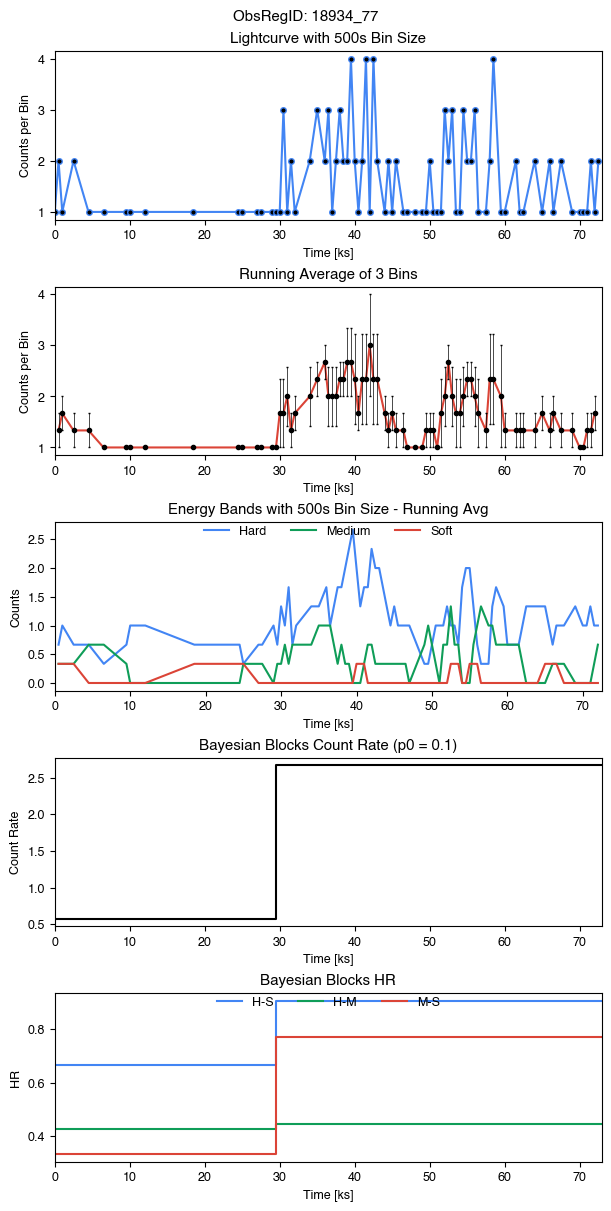

Name: 2CXO J022719.8+613417, ID: 18934-87, Date: 2017-11-25T03:47:47, Counts: 128
RA  36.83252862555071 DEC  61.57151225202746
varB  1.0 varH  1.0 varM  1.0 varS  nan varINDEX  9.0


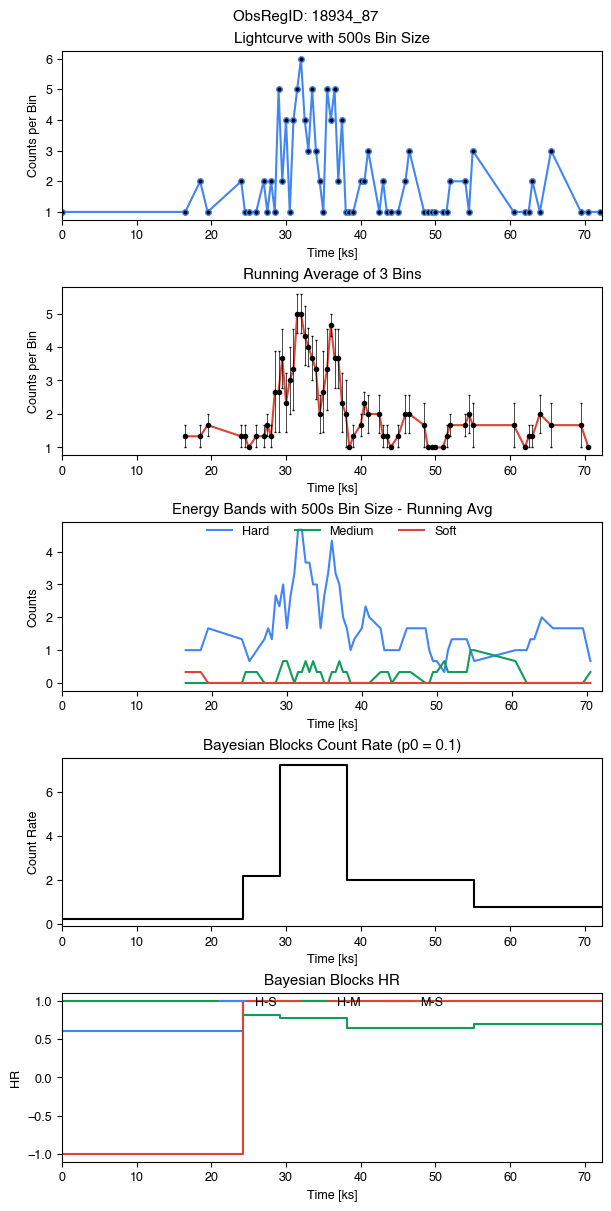

Name: 2CXO J095628.2+285123, ID: 19333-32, Date: 2018-01-16T18:50:54, Counts: 124
RA  149.11716271891078 DEC  28.856645158741067
varB  1.0 varH  1.0 varM  1.0 varS  1.0 varINDEX  10.0


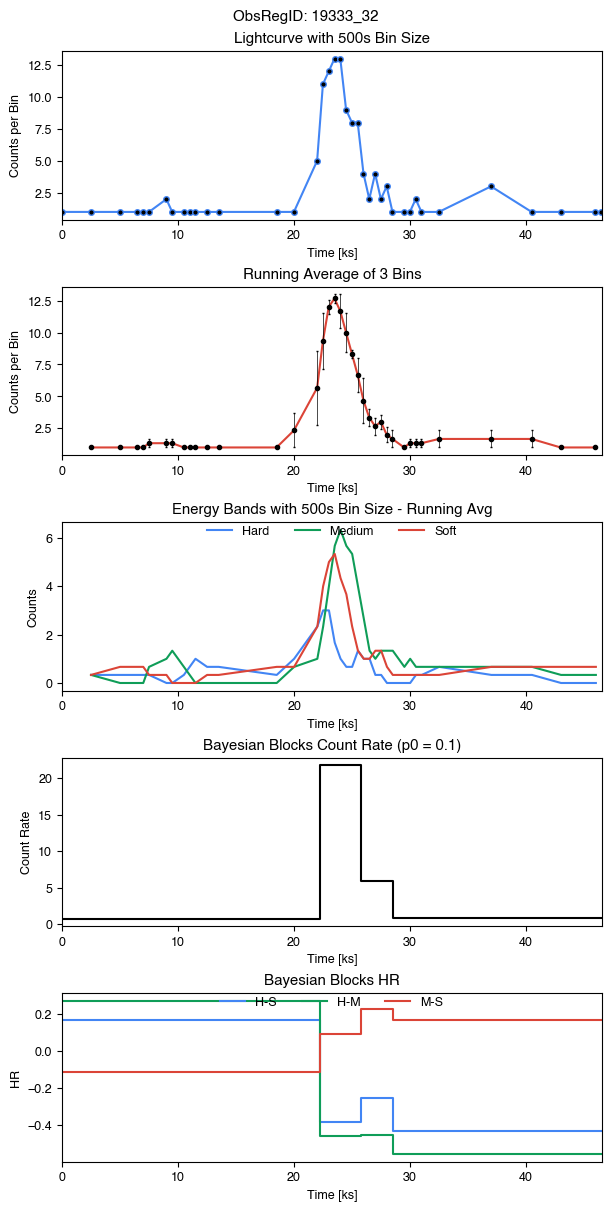

Name: 2CXO J170921.0-442354, ID: 20299-70, Date: 2018-06-26T18:48:57, Counts: 80
RA  257.33765193177817 DEC  -44.398559799950846
varB  1.0 varH  1.0 varM  0.99 varS  nan varINDEX  8.0


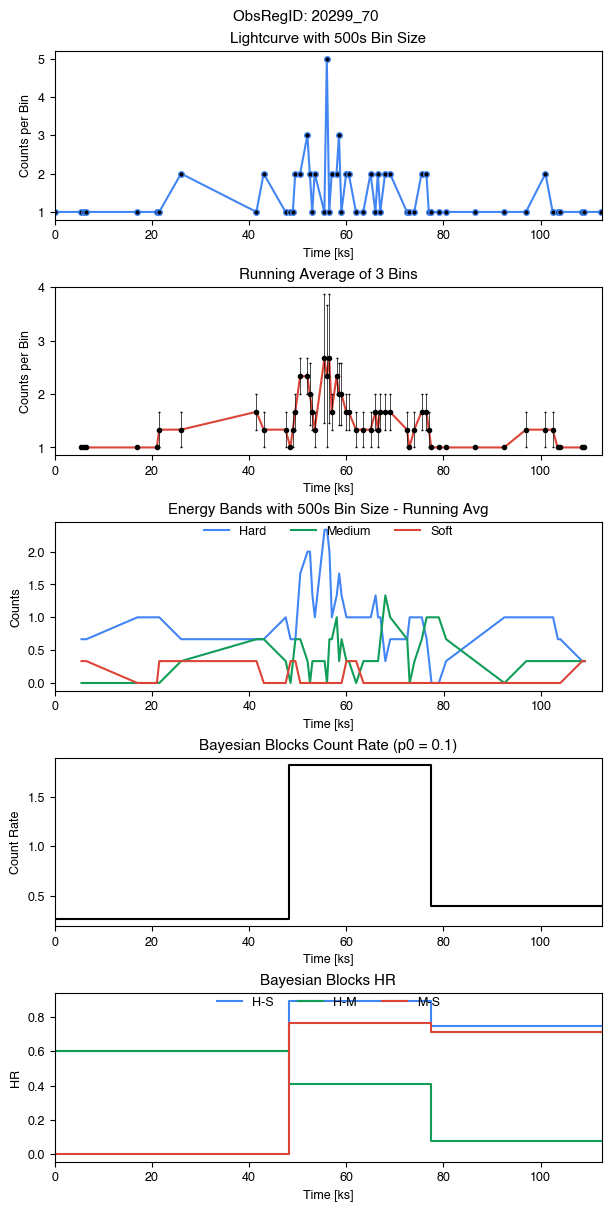

Name: 2CXO J063259.3+055437, ID: 20950-48, Date: 2018-02-04T12:19:58, Counts: 141
RA  98.24744269714472 DEC  5.910320855656744
varB  1.0 varH  1.0 varM  1.0 varS  1.0 varINDEX  9.0


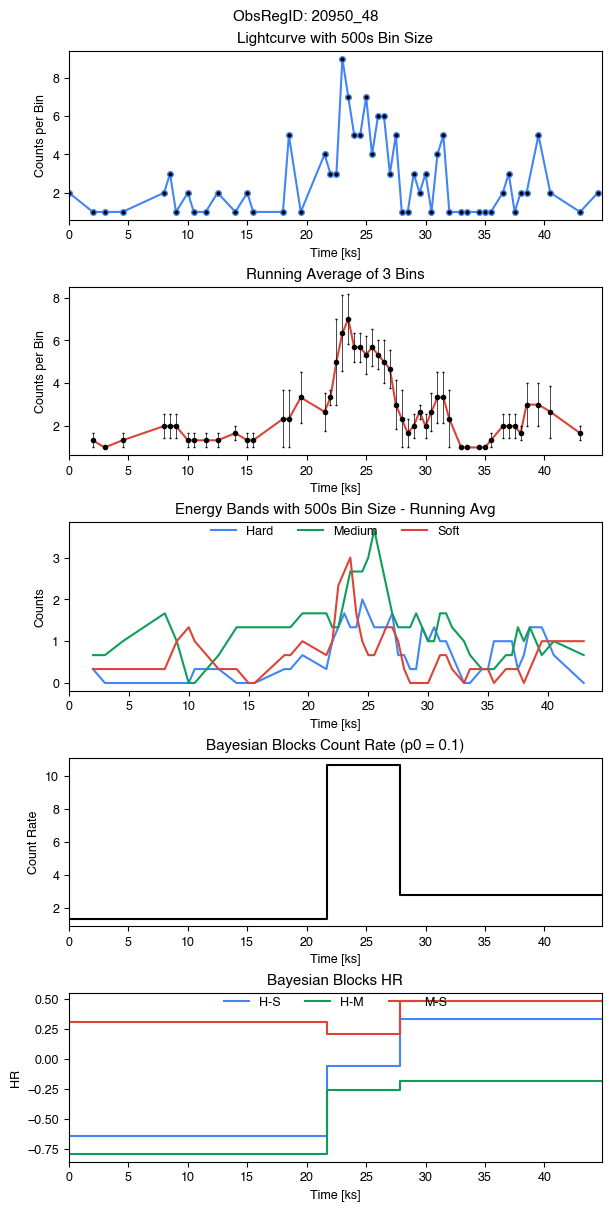

Name: 2CXO J175108.5-262003, ID: 21127-175, Date: 2018-07-21T00:55:11, Counts: 74
RA  267.7855772343928 DEC  -26.334273330883896
varB  1.0 varH  1.0 varM  1.0 varS  nan varINDEX  9.0


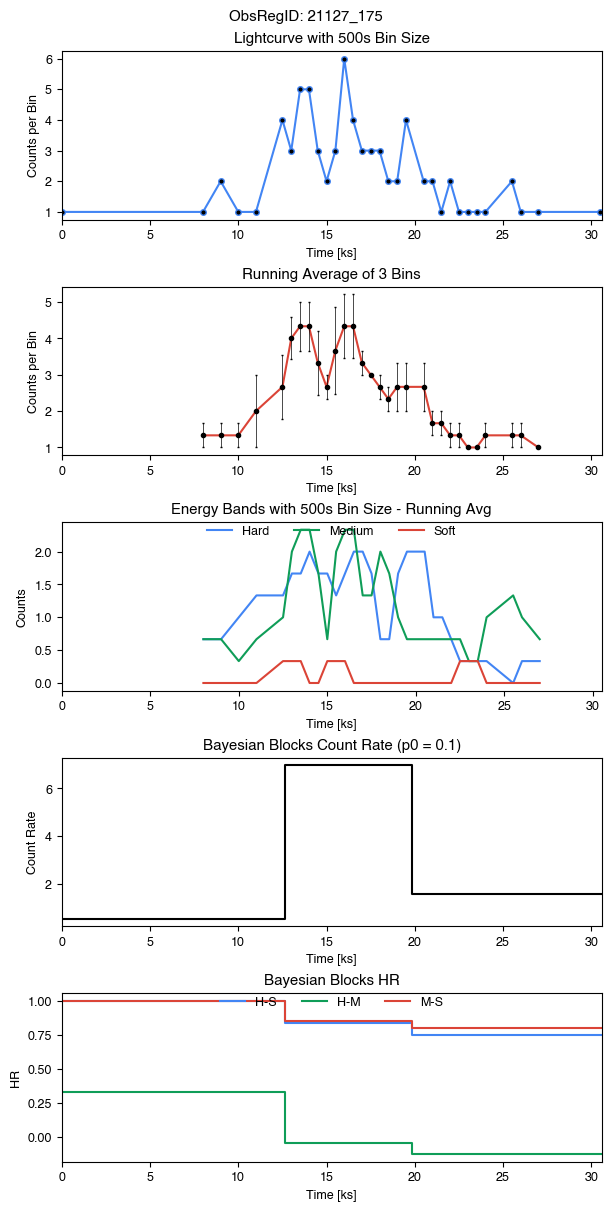

Name: 2CXO J180237.5-223815, ID: 21153-31, Date: 2019-07-29T16:43:43, Counts: 81
RA  270.6563754659967 DEC  -22.63776439796534
varB  1.0 varH  1.0 varM  1.0 varS  0.82 varINDEX  10.0


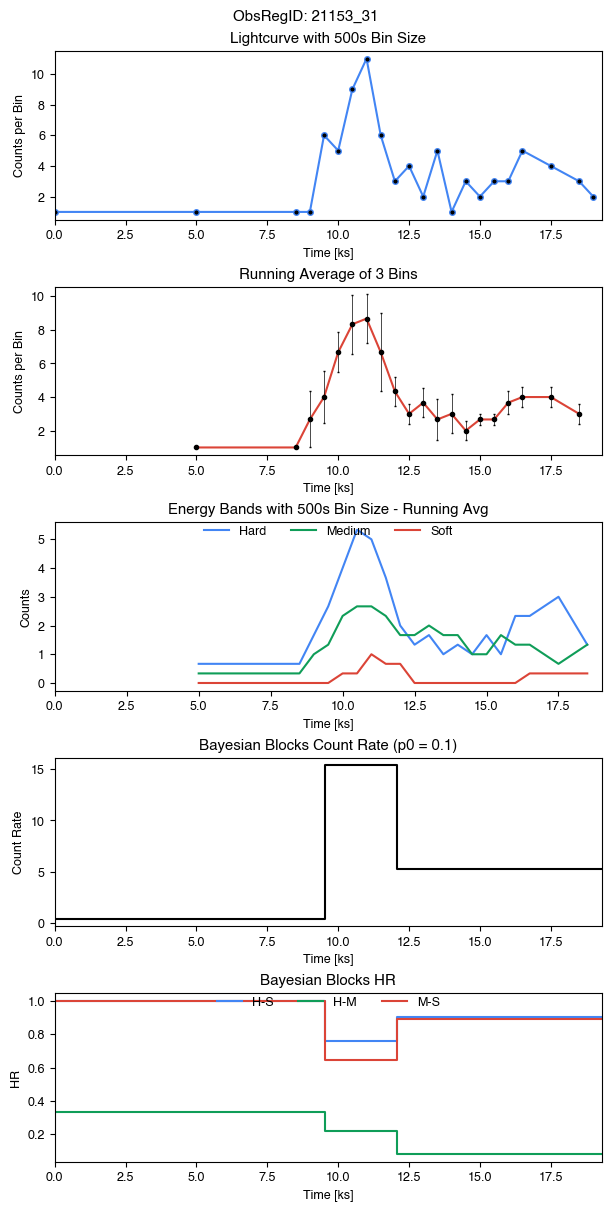

Name: 2CXO J101523.0-585852, ID: 21357-7, Date: 2019-09-24T10:56:03, Counts: 103
RA  153.8459637127055 DEC  -58.98114641091074
varB  0.5 varH  nan varM  0.77 varS  0.45 varINDEX  1.0


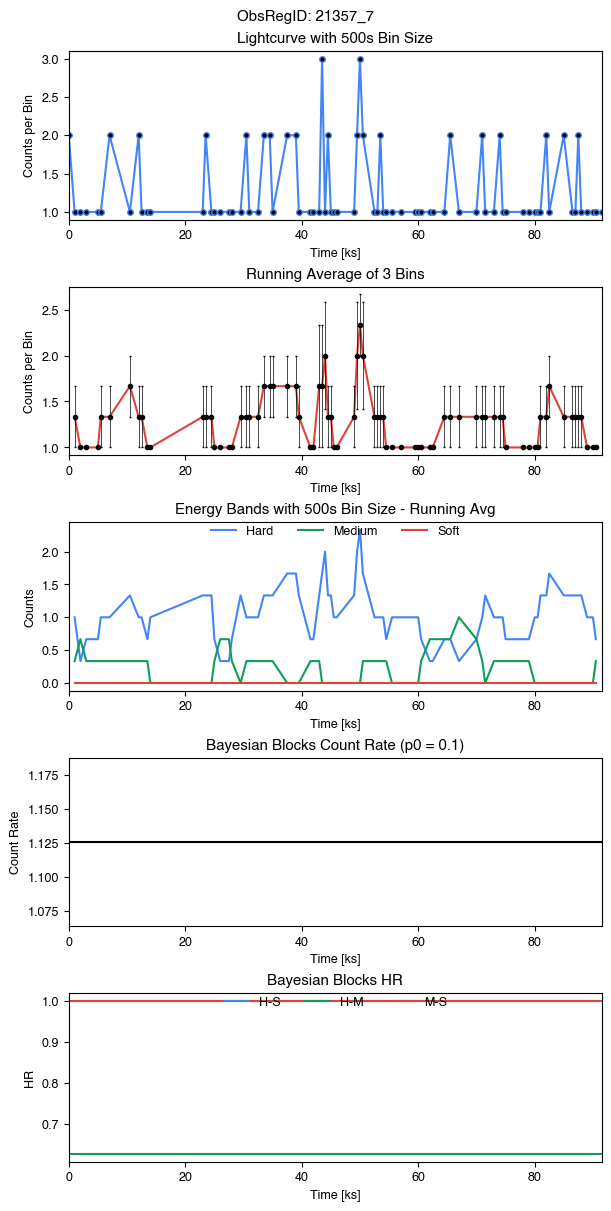

Name: 2CXO J101529.2-585744, ID: 21357-9, Date: 2019-09-24T10:56:03, Counts: 103
RA  153.87196989683628 DEC  -58.96243188764844
varB  0.18 varH  0.59 varM  0.37 varS  nan varINDEX  0.0


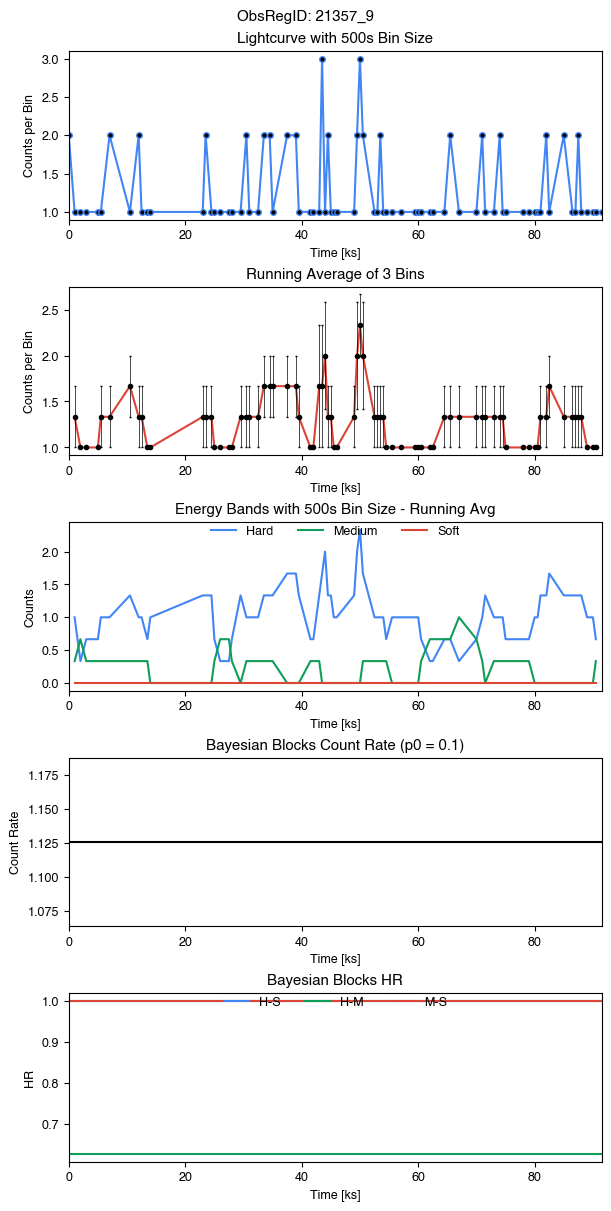

Name: 2CXO J143030.6+524321, ID: 21428-5, Date: 2020-03-21T05:53:21, Counts: 175
RA  217.6277929812867 DEC  52.72261570401885
varB  1.0 varH  1.0 varM  1.0 varS  0.2 varINDEX  8.0


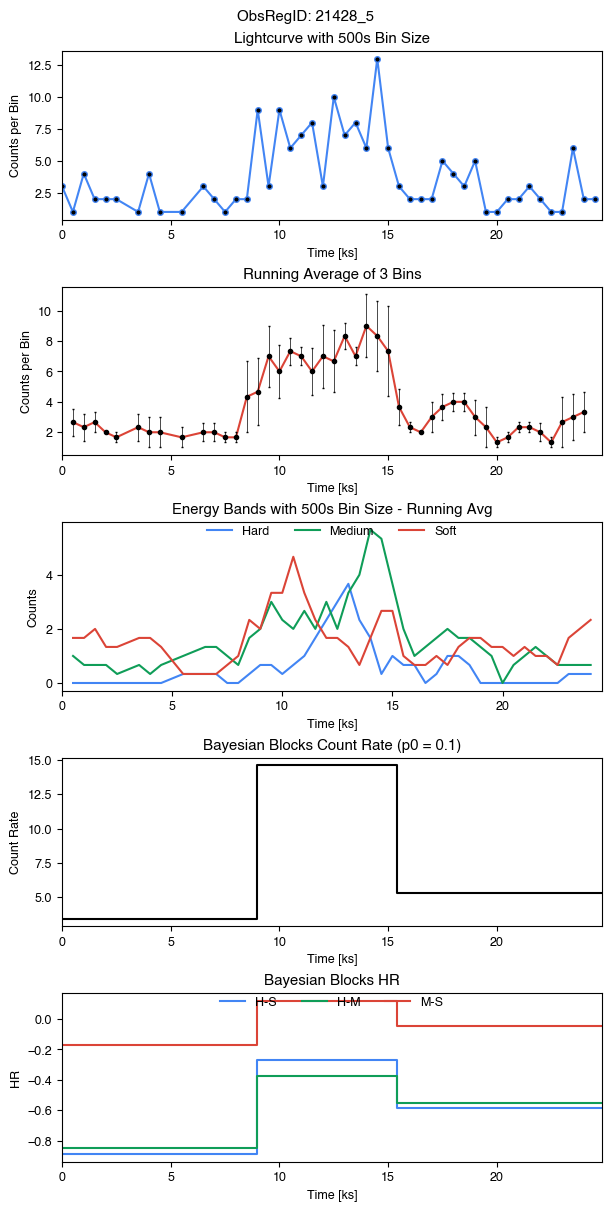

Name: 2CXO J233412.2-525835, ID: 21705-52, Date: 2020-03-15T08:02:09, Counts: 65
RA  353.5508390069855 DEC  -52.97641419938993
varB  1.0 varH  1.0 varM  1.0 varS  nan varINDEX  9.0


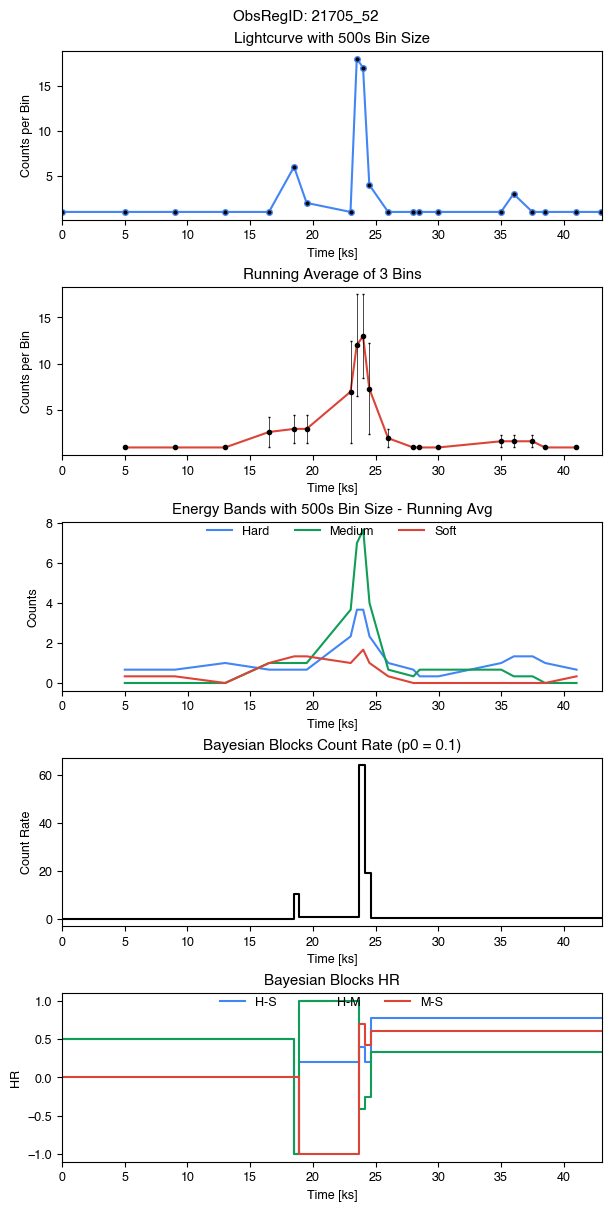

Name: 2CXO J102408.9-574344, ID: 21848-766, Date: 2018-09-21T21:35:10, Counts: 133
RA  156.0371796710631 DEC  -57.729062975175125
varB  1.0 varH  1.0 varM  1.0 varS  nan varINDEX  9.0


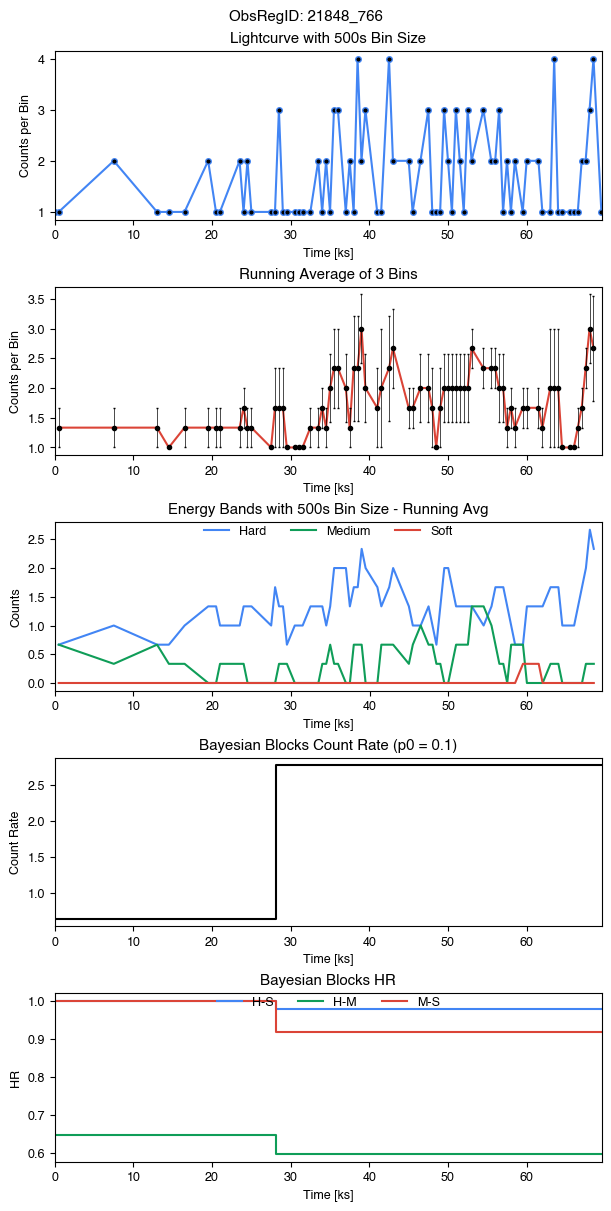

Name: 2CXO J042130.9+202954, ID: 24386-37, Date: 2020-11-20T12:30:51, Counts: 79
RA  65.37897042747773 DEC  20.498392532862145
varB  1.0 varH  1.0 varM  0.53 varS  nan varINDEX  8.0


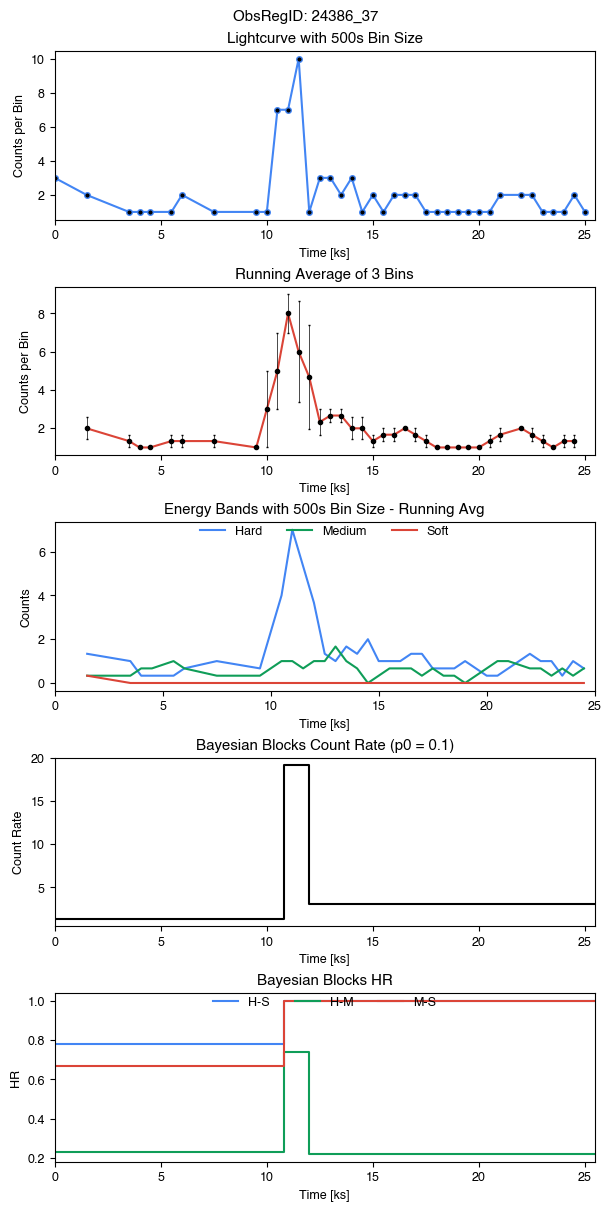

In [19]:
# ###
# df_properties_anomalies = df_properties_anomalies2 # comment out for clusters
# df_select = points_in_box# comment out for clusters
# df_properties_anomalies = df_properties_anomalies[df_properties_anomalies['var_index_b']>5] #COMMENT OUT

years = range(2015,2023)
years_string = [str(year) for year in years]
pattern = '|'.join(years_string)
df_properties_anomalies_filt = df_properties_anomalies[df_properties_anomalies['gti_obs'].str.contains(pattern)]

potential_anomalies = df_properties_anomalies_filt['obsreg_id']
# potential_anomalies = df_select['obsreg_id']
print(len(potential_anomalies))
keep = potential_anomalies.values[0:100]


# keep = ['13814_86','2540_253','633_2117']
# keep = ['6442_37','11231_250','5424_145','16000_221']
# keep = ['3012_53','3744_830','4373_662','4396_2625','13117_169','13653_40','6291_253']
# keep = ['12330_2071','10135_343','11073_116','11073_116','13951_16']
# keep = potential_anomalies.values
# keep = ['9912_482']
years = range(2015,2023)
# Image producer
# keep = all_ids[50000:55000]
df_eventfiles_group_filtered = df_eventfiles_group.filter(lambda x: x.name in keep).groupby('obsreg_id')
for id_name, dfi in df_eventfiles_group_filtered:
    dfi.sort_values(by='time', inplace = True) 
    dfi.reset_index(drop=True, inplace = True)
    obsid = id_name.split("_")[0]
    regionid = id_name.split("_")[1]
    # Get property columns
    name = df_properties_anomalies[df_properties_anomalies['obsreg_id'] == id_name].name.values[0]
    ra = df_properties_anomalies[df_properties_anomalies['obsreg_id'] == id_name].ra.values[0]
    dec = df_properties_anomalies[df_properties_anomalies['obsreg_id'] == id_name].dec.values[0]
    date = df_properties_anomalies[df_properties_anomalies['obsreg_id'] == id_name].gti_obs.values[0] 
    var_prob_b = df_properties_anomalies[df_properties_anomalies['obsreg_id'] == id_name].var_prob_b.values[0]
    var_prob_h = df_properties_anomalies[df_properties_anomalies['obsreg_id'] == id_name].var_prob_h.values[0]
    var_prob_m = df_properties_anomalies[df_properties_anomalies['obsreg_id'] == id_name].var_prob_m.values[0]
    var_prob_s = df_properties_anomalies[df_properties_anomalies['obsreg_id'] == id_name].var_prob_s.values[0] 
    var_index_b = df_properties_anomalies[df_properties_anomalies['obsreg_id'] == id_name].var_index_b.values[0]
    # Get spectrum
    # pha_filename = [spec for spec in glob.iglob(f'{pha_folder}/acisf*pha3.fits.gz') if str(obsid) in spec and str(regionid) in spec][0]
    # ui.load_pha(pha_filename)
    # ui.ignore('0.:0.5,8.0:')
    # ui.subtract()
    # ui.notice_id(1,0.3,7.)
    # ui.group_counts(10)
    # ui.set_ylog()
    # ui.set_xlog()
    # ui.plot_data(color='red')
    # plt.xlim(1E-1,10)  
    # plt.show(

    if any(str(year) in date for year in years):
        print(f'Name: {name}, ID: {obsid}-{regionid}, Date: {date}, Counts: {len(dfi)}')
        print('RA ', str(ra), 'DEC ', str(dec))
        print('varB ', str(round(var_prob_b,2)), 'varH ', str(round(var_prob_h,2)),'varM ', str(round(var_prob_m,2)),'varS ', str(round(var_prob_s,2)),'varINDEX ', str(var_index_b))
        lightcurveplotterNEW(dfi,id_name,500,bb_p0=0.1,band_errors=False)
        # lightcurveplotterNEW(dfi,id_name,len(dfi)/100,bb_p0=0.1,band_errors=False)
    else:
        pass
    # # hist2D(dfi,id_name,16,24,'minmax',True,'plasma',lognorm=True)
    # # hist2D(dfi,id_name,16,24,'minmax',True,'plasma',lognorm=False)
    # hist3D(dfi,id_name,16,24,24,'minmax',True,'plasma',lognorm=True)
    #hist3D(dfi,id_name,16,24,24,'minmax',True,'plasma',lognorm=False)
    # hist3Dlog(dfi,id_name,16,24,24,'minmax',True,'plasma')

In [31]:
potential_anomalies = df_properties_anomalies['obsreg_id']
df_properties_anomalies = df_properties_global[df_properties_global['obsreg_id'].isin(potential_anomalies)]
# keep = ['13814_86','2540_253','633_2117']
keep = ['4373_704','17196_22']
keep = potential_anomalies
keep = ['4373_704','17196_22','5322_229']
df_properties_anomalies = df_properties_global[df_properties_global['obsreg_id'].isin(keep)]
df_properties_anomalies.head(500)

name          ra        dec  err_ellipse_r0   
33394  2CXO J053524.1-052132   83.850449  -5.359066        0.711036  \
77440  2CXO J131531.7-162723  198.882148 -16.456599        0.710691   
84683  2CXO J140414.2+542604  211.059111  54.434571        0.711382   

       err_ellipse_r1  err_ellipse_ang  significance likelihood_class   
33394        0.710252        98.802834     37.030891             TRUE  \
77440        0.710518       158.198352     50.785932             TRUE   
84683        0.710545        58.332784     72.109780             TRUE   

       conf_flag  sat_src_flag  ...  hard_hs_hilim  var_prob_b  var_prob_h   
33394      False         False  ...      -0.347908         1.0    1.000000  \
77440      False         False  ...      -0.883823         1.0    1.000000   
84683       True         False  ...      -0.576515         1.0    0.163951   

       var_prob_m  var_prob_s  var_index_b  var_index_w       livetime   
33394    1.000000    1.000000         10.0          NaN  171465.489393  \
77440    1.000000    1.000000         10.0          NaN   88865.338014   
84683    0.841169    0.117768          8.0          NaN   64696.624674   

       detector  obsreg_id  
33394    ACIS-3   4373_704  
77440    ACIS-6   17196_22  
84683    ACIS-8   5322_229  

[3 rows x 76 columns]

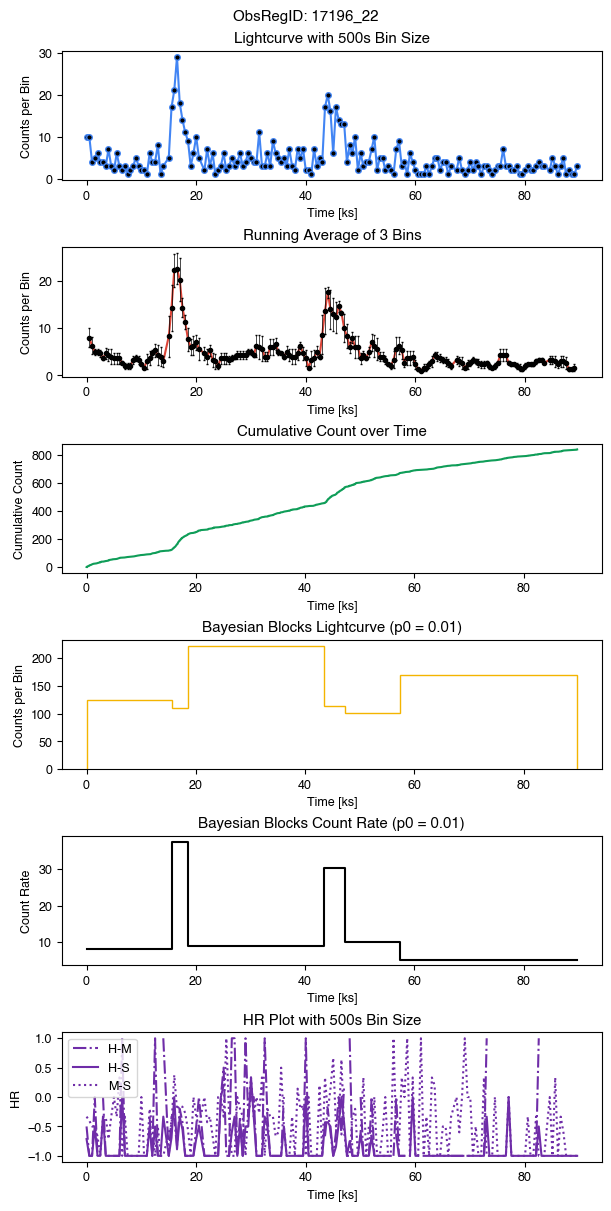

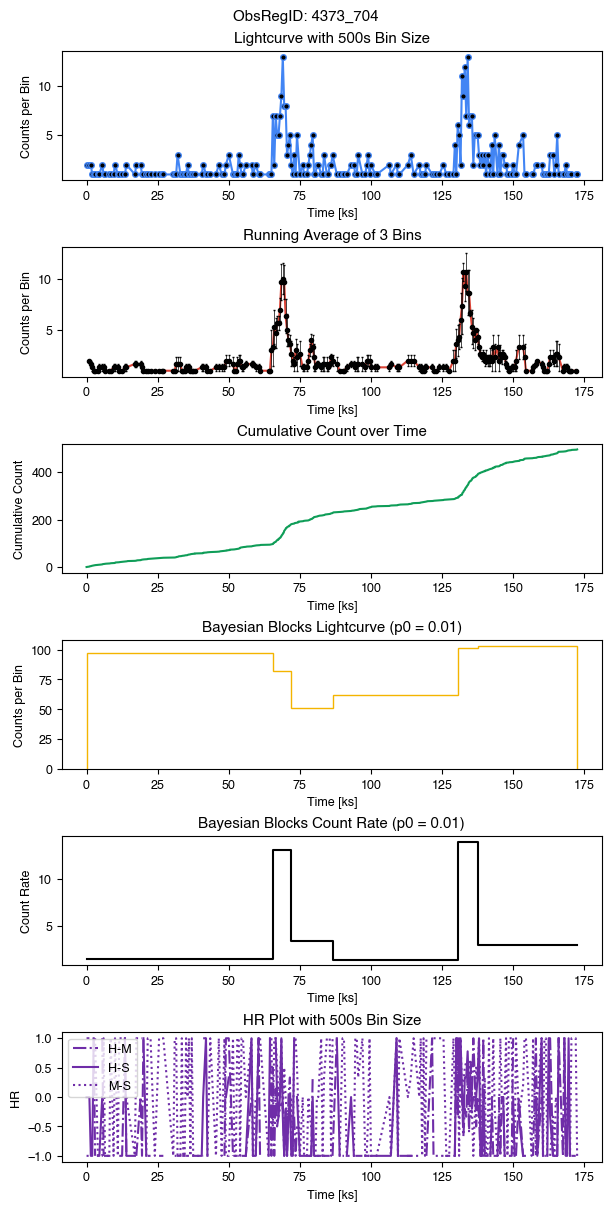

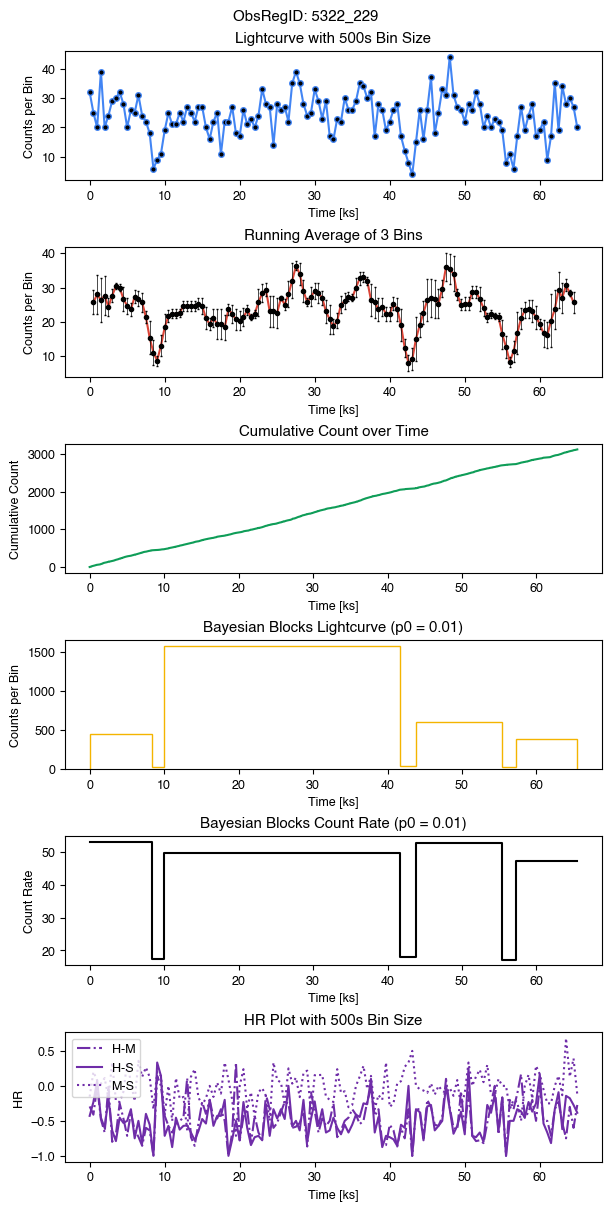

In [66]:
df_eventfiles_group_filtered = df_eventfiles_group.filter(lambda x: x.name in keep).groupby('obsreg_id')
for id_name, dfi in df_eventfiles_group_filtered:
    dfi.sort_values(by='time', inplace = True) 
    dfi.reset_index(drop=True, inplace = True)
    lightcurveplotter(dfi,id_name,500,bb_p0=0.01)